# Loading The Data Sets


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [3]:
# Cite: https://www.kaggle.com/code/cchangyyy/0-490-notebook


# Processes a parquet file
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, "part-0.parquet"))
    df.drop("step", axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split("=")[1]


def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(lambda fname: process_file(fname, dirname), ids),
                total=len(ids),
            )
        )
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df["id"] = indexes
    return df

In [4]:
# Loading the train and test data sets
# Aligning train dataset columns to match test dataset
# Checking for column differences between train and test datasets

# CP: Running locally
if os.path.exists("kaggle_data"):
    train_data = pd.read_csv("kaggle_data/train.csv")
    test_data = pd.read_csv("kaggle_data/test.csv")
    train_ts = load_time_series("kaggle_data/series_train.parquet")
    test_ts = load_time_series("kaggle_data/series_test.parquet")

# CP: Running in Kaggle
else:
    train_data = pd.read_csv(
        "/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"
    )
    test_data = pd.read_csv(
        "/kaggle/input/child-mind-institute-problematic-internet-use/test.csv"
    )
    train_ts = load_time_series(
        "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet"
    )
    test_ts = load_time_series(
        "/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet"
    )


column_names = list(test_data.columns)
target = train_data["sii"]
train_data = pd.DataFrame(train_data, columns=column_names)
train_data["sii"] = target
print(train_data.columns.difference(test_data.columns))
print(train_data.shape)
print(test_data.shape)

100%|██████████| 2/2 [00:00<00:00, 17.59it/s]

Index(['sii'], dtype='object')
(3960, 60)
(20, 59)


In [5]:
# Cite: https://www.kaggle.com/code/cchangyyy/0-490-notebook

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")
train_data = pd.merge(train_data, train_ts, how="left", on="id")
test_data = pd.merge(test_data, test_ts, how="left", on="id")
train_data = train_data.drop("id", axis=1)

In [6]:
# # Make a copy (comment on/off)
# train_data_copy = train_data.copy()
# test_data_copy = test_data.copy()

# Data Visualization


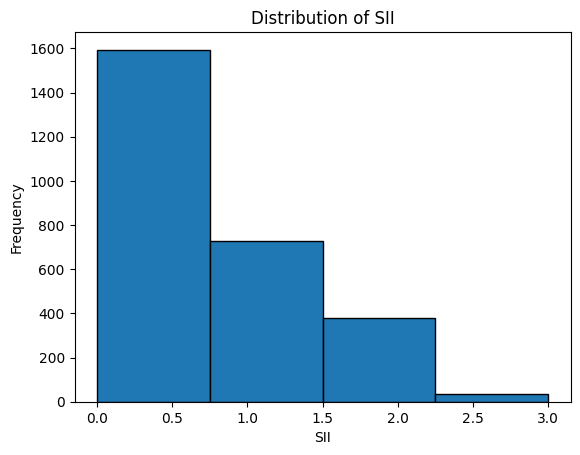

In [7]:
plt.hist(train_data["sii"].dropna(), bins=4, edgecolor="k")
plt.title("Distribution of SII")
plt.xlabel("SII")
plt.ylabel("Frequency")
plt.show()

In [8]:
df_cat = train_data.select_dtypes(include=["object"])
df_num = train_data.select_dtypes(include=["int64", "float64"])

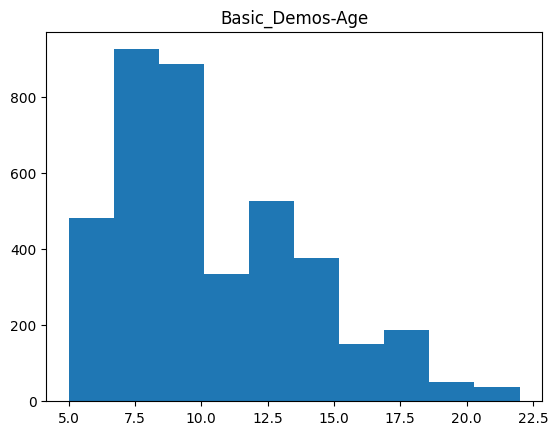

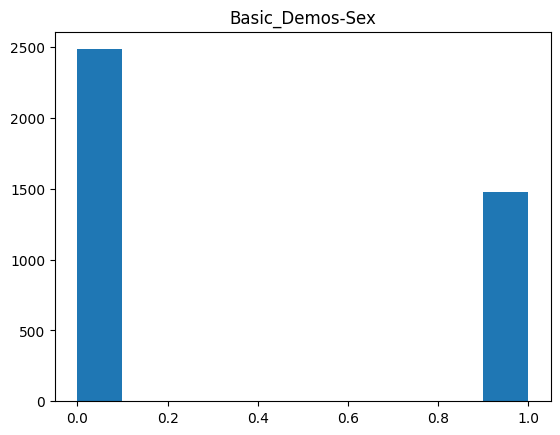

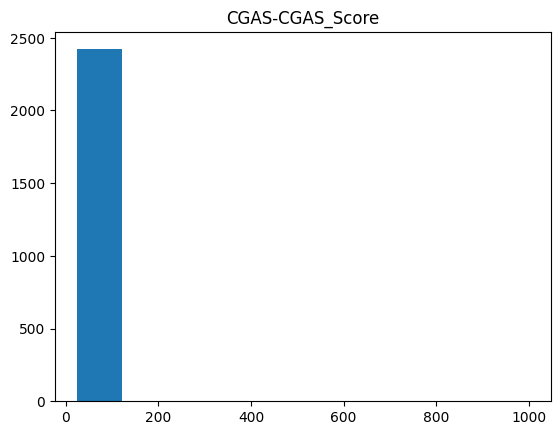

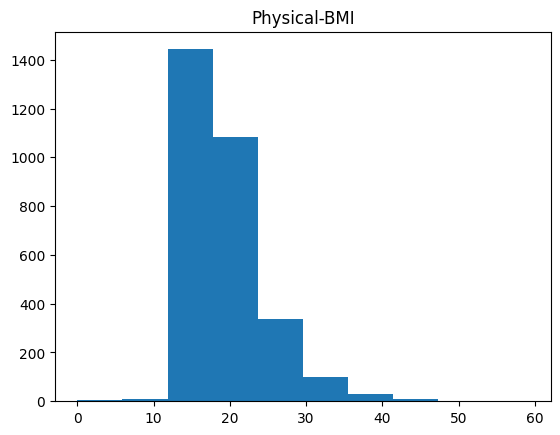

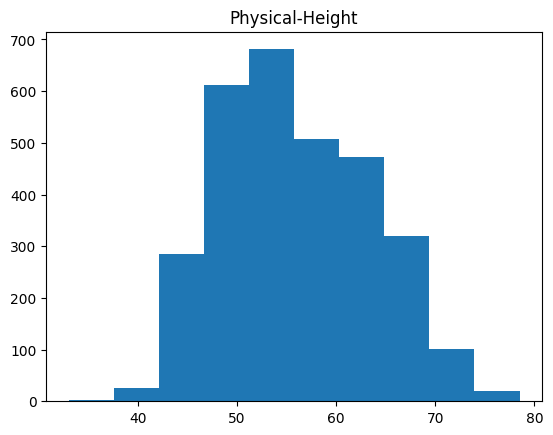

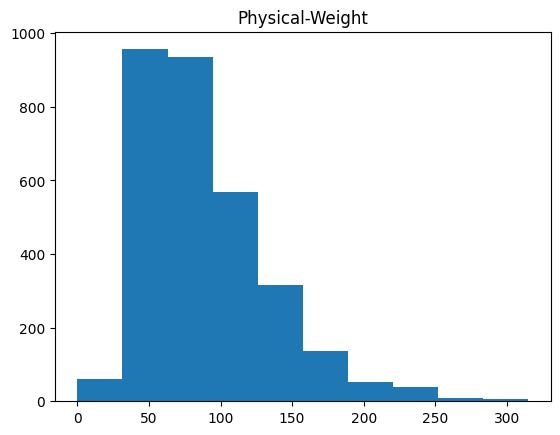

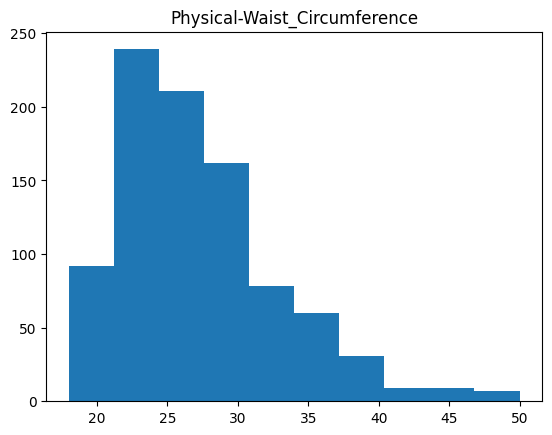

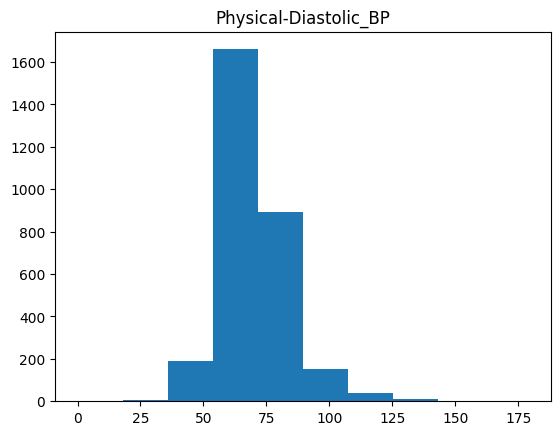

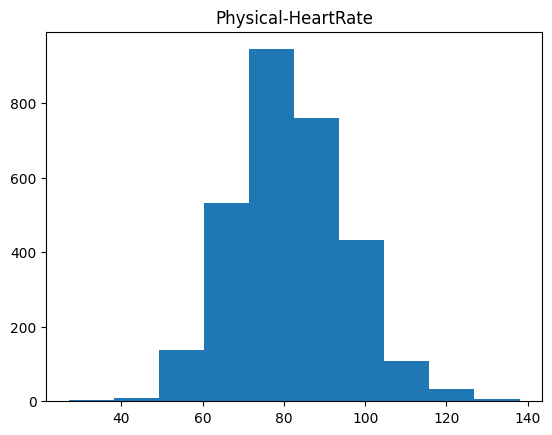

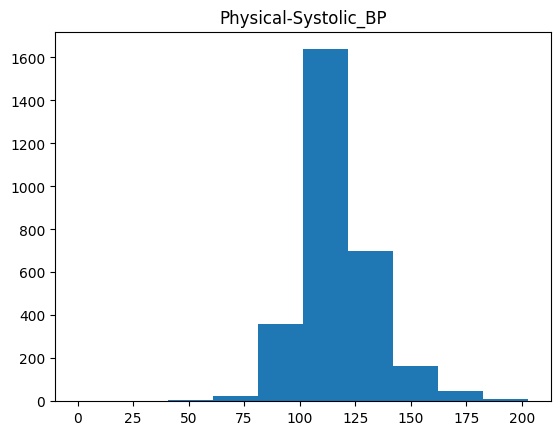

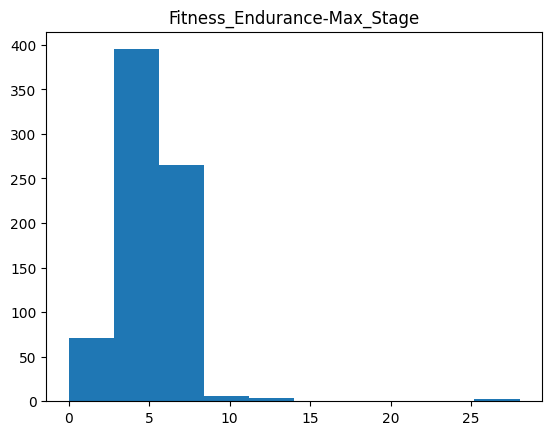

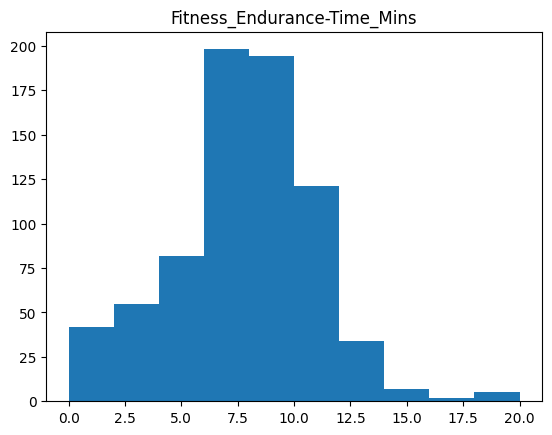

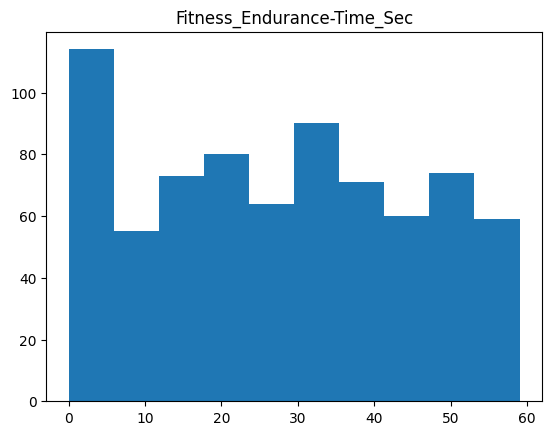

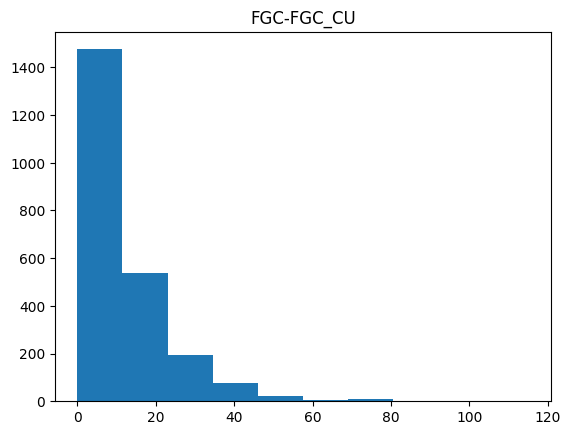

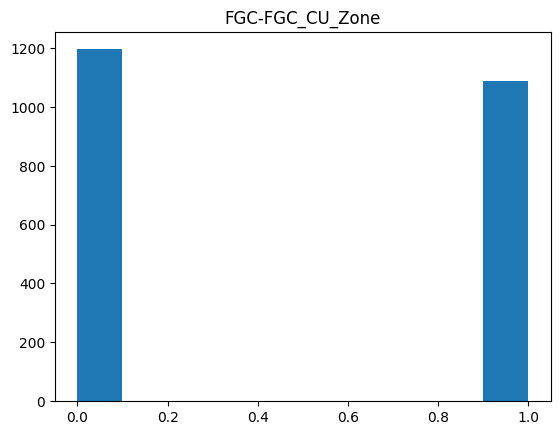

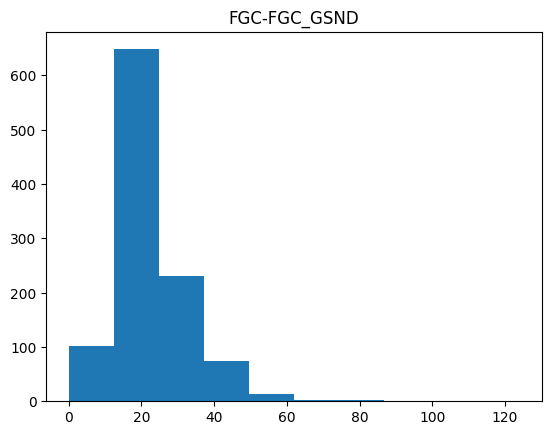

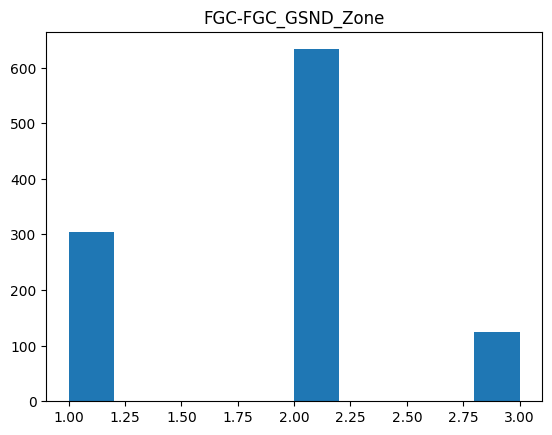

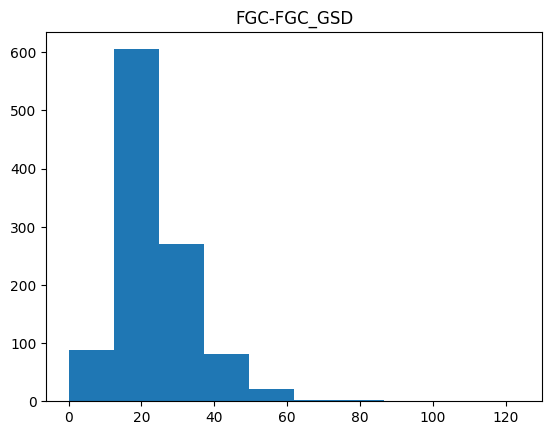

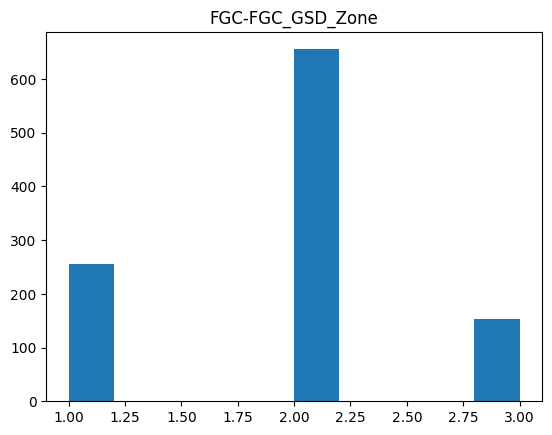

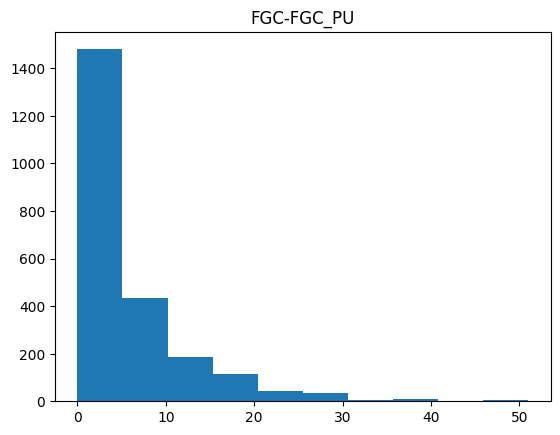

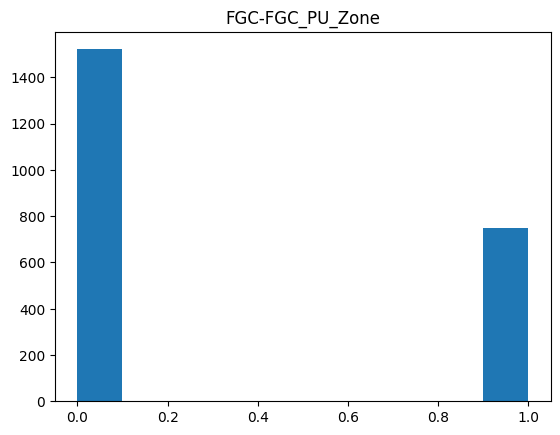

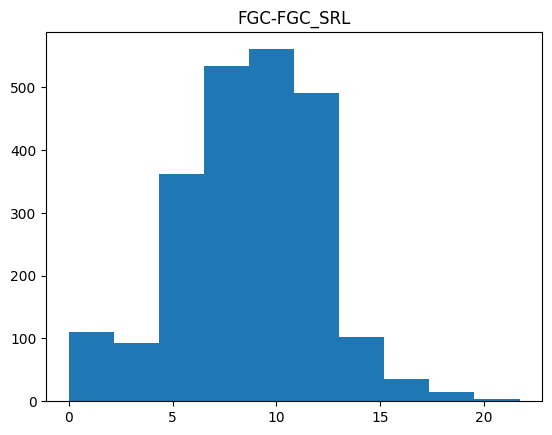

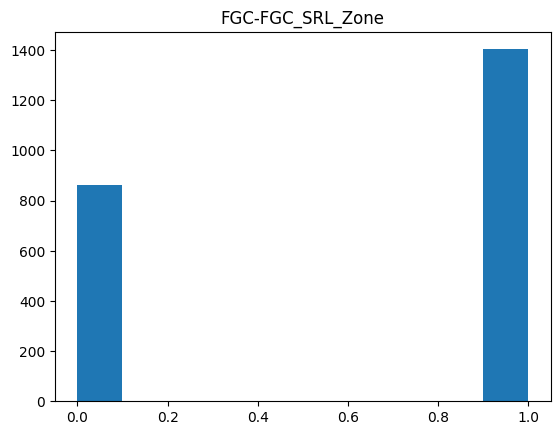

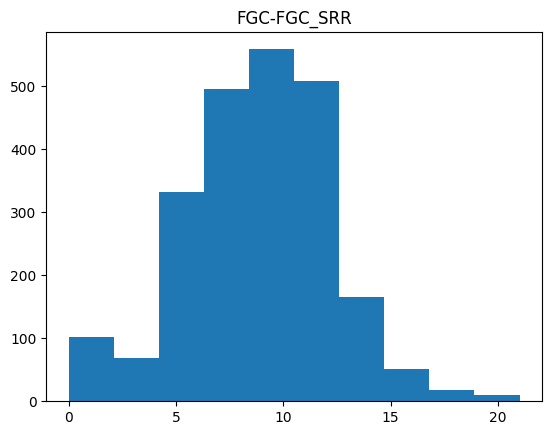

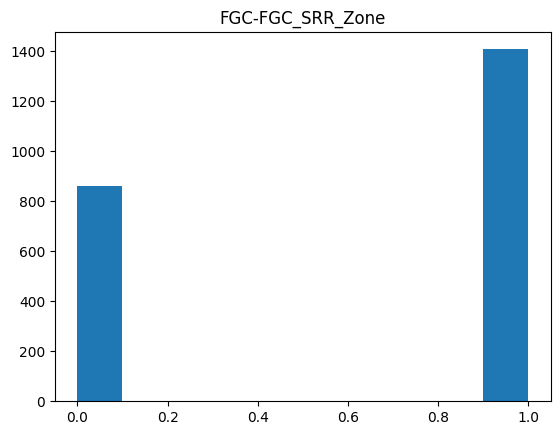

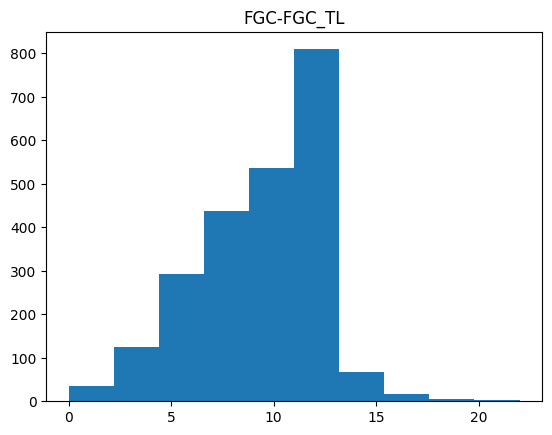

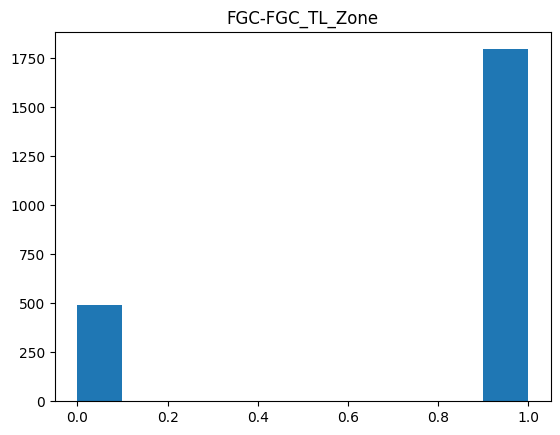

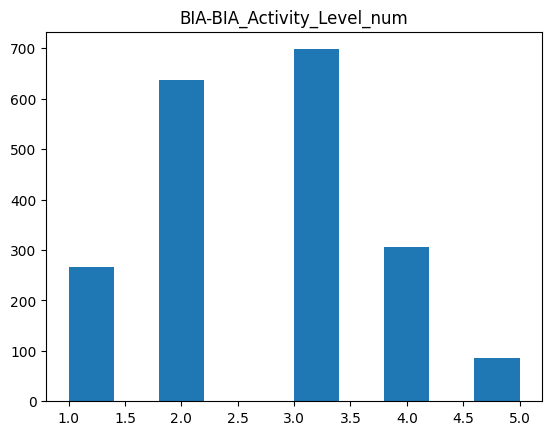

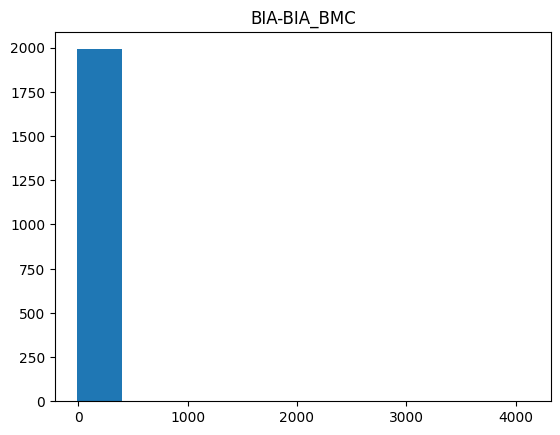

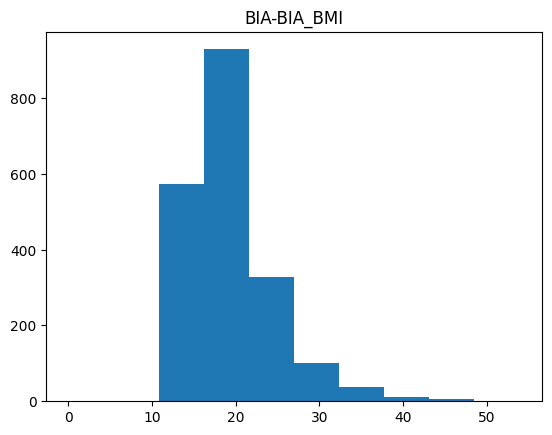

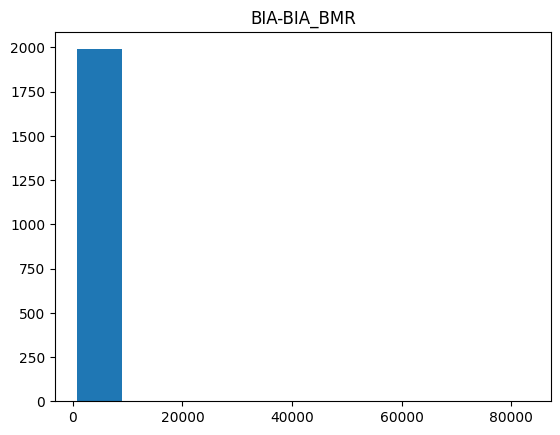

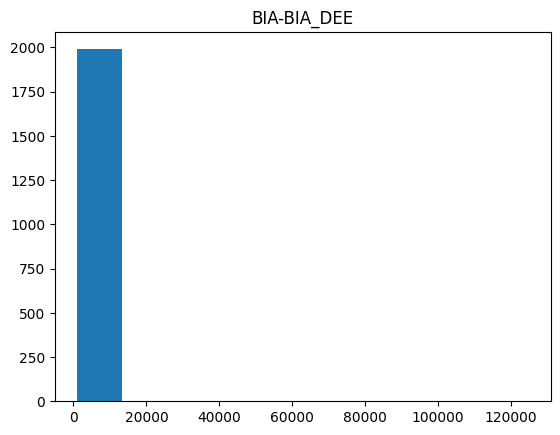

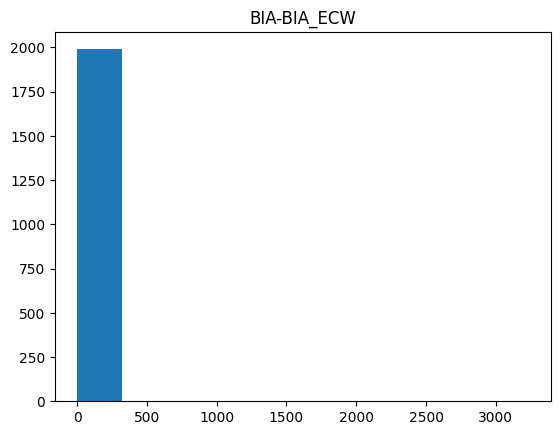

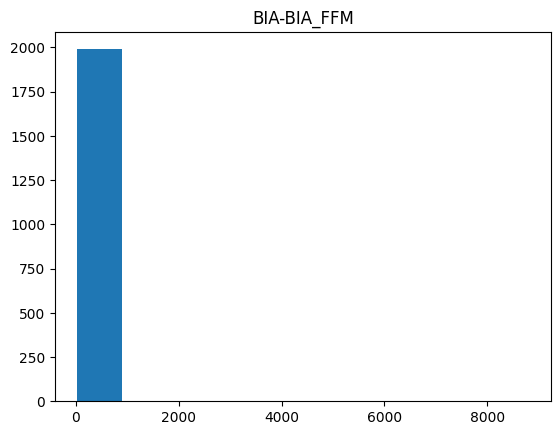

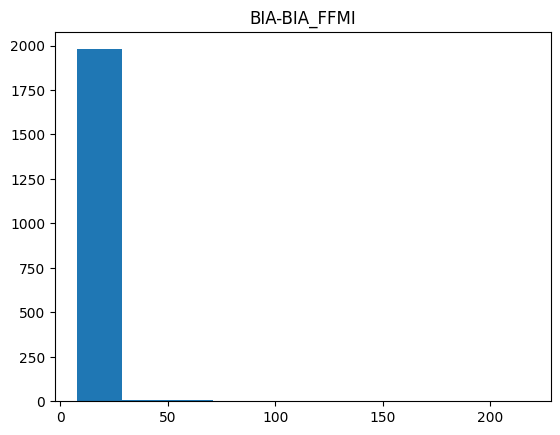

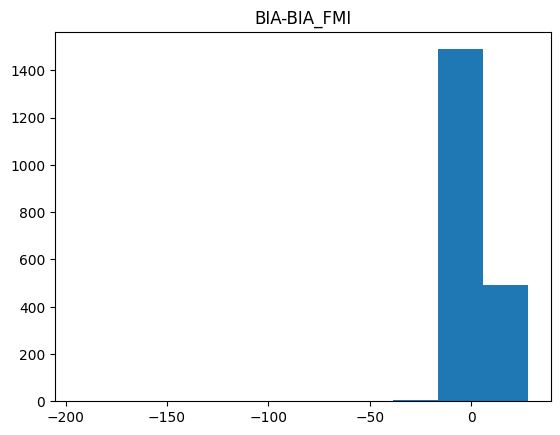

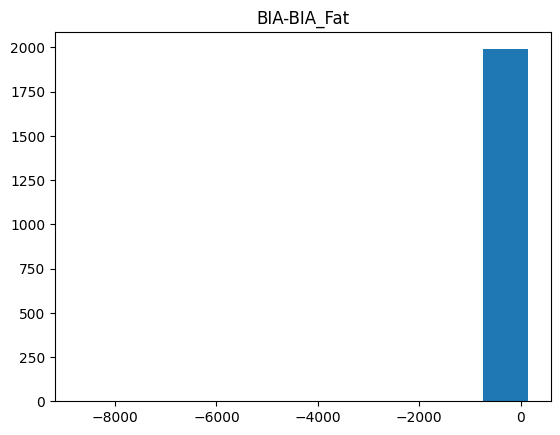

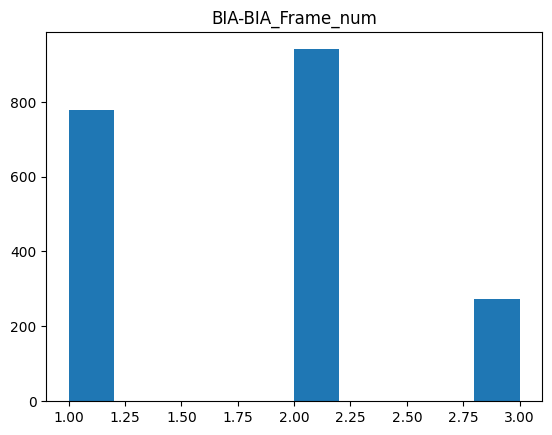

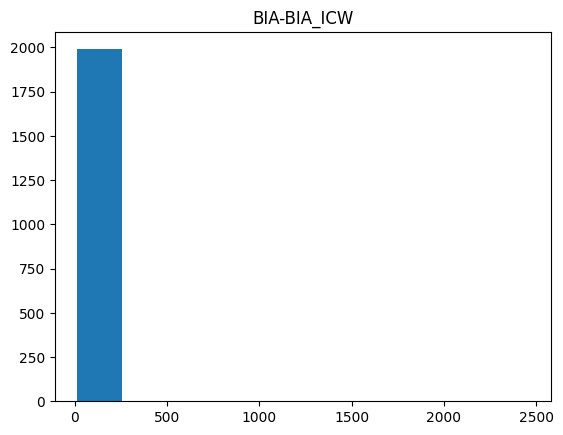

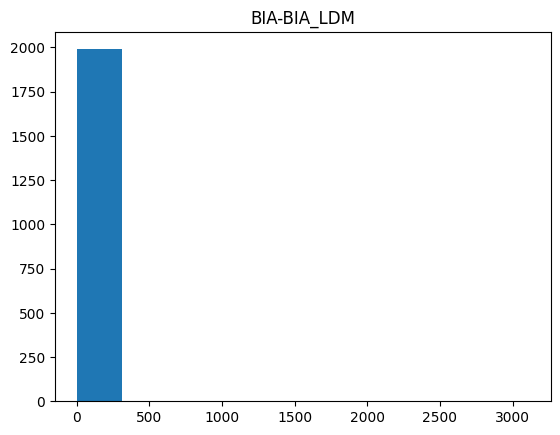

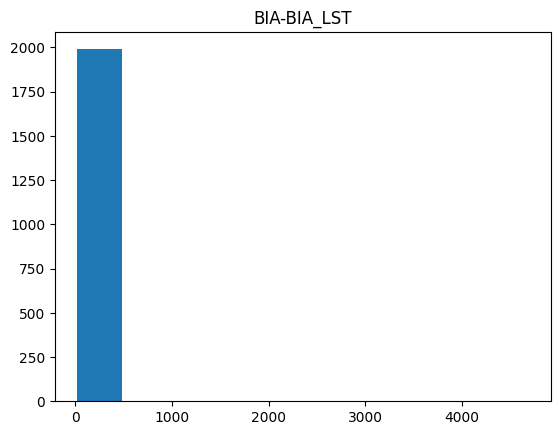

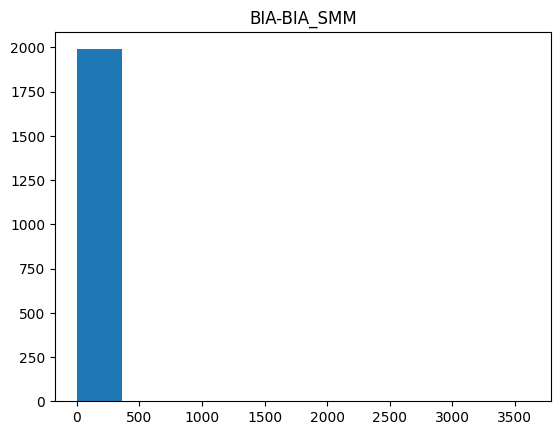

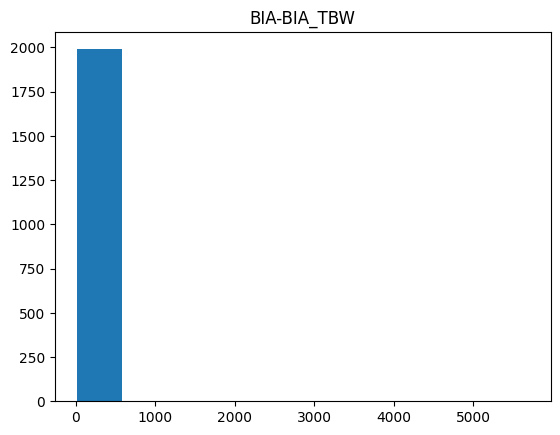

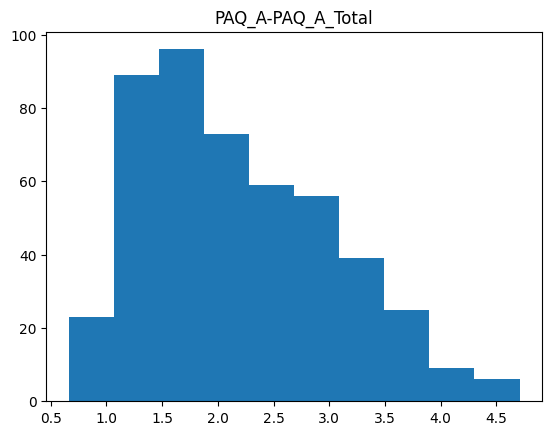

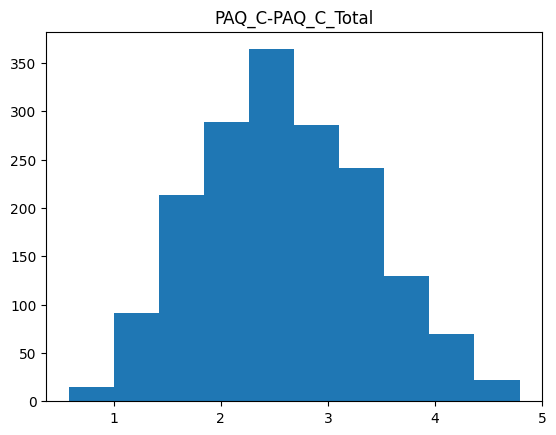

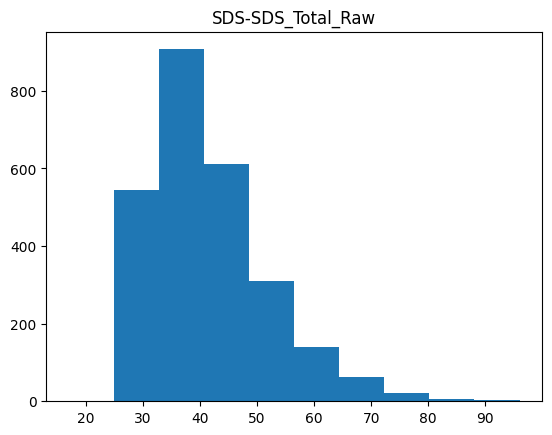

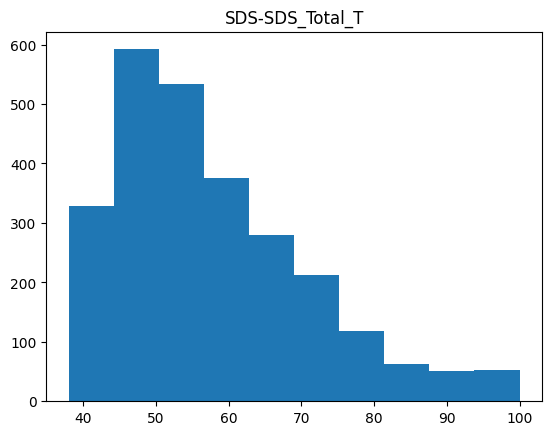

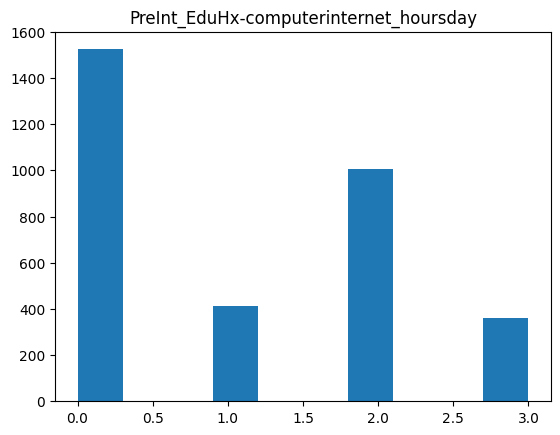

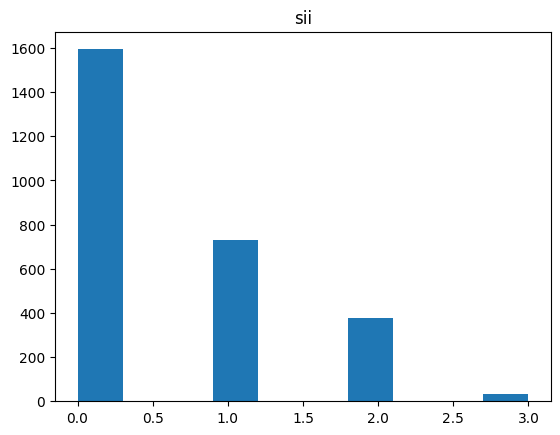

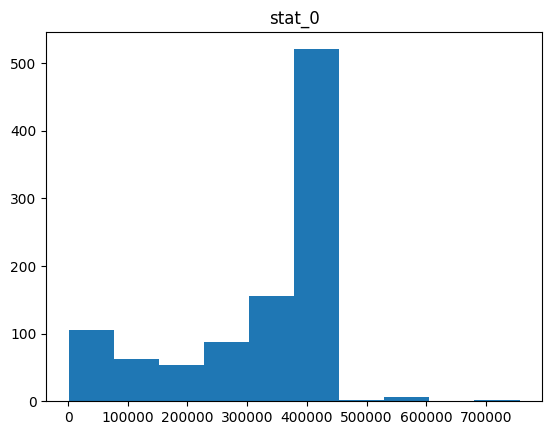

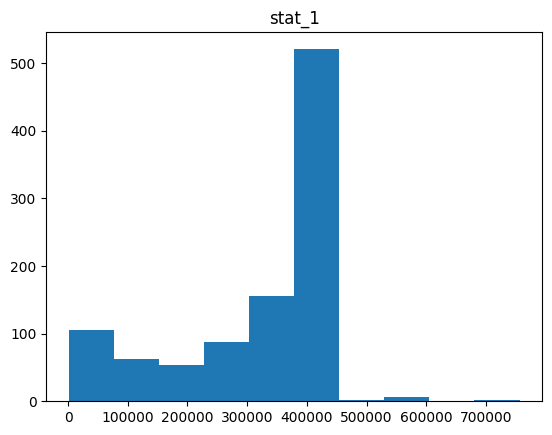

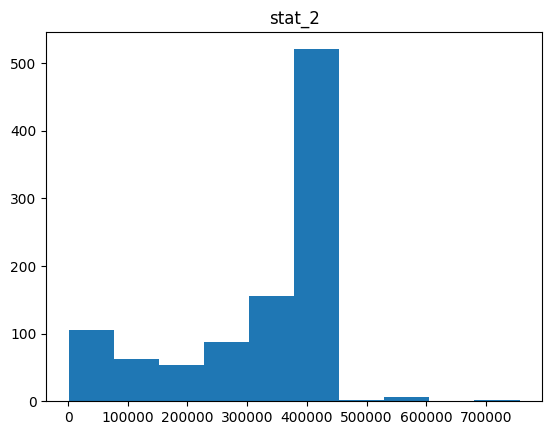

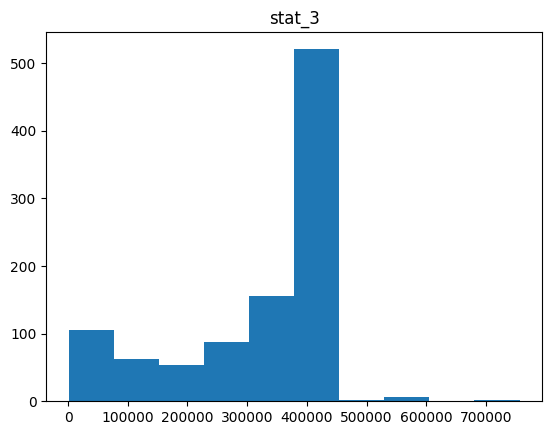

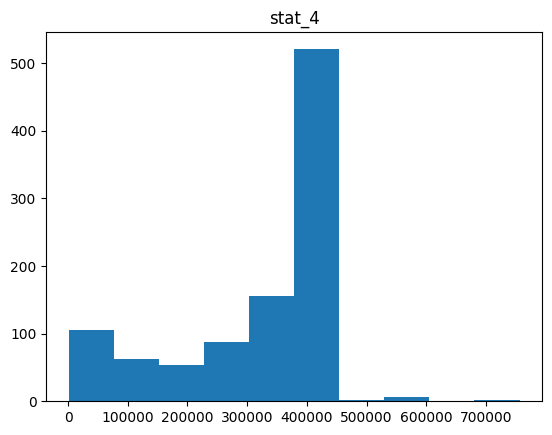

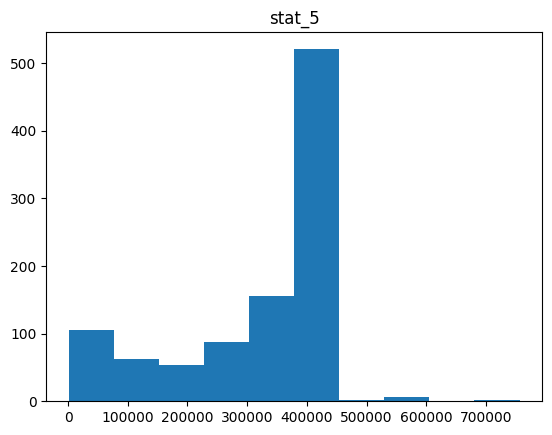

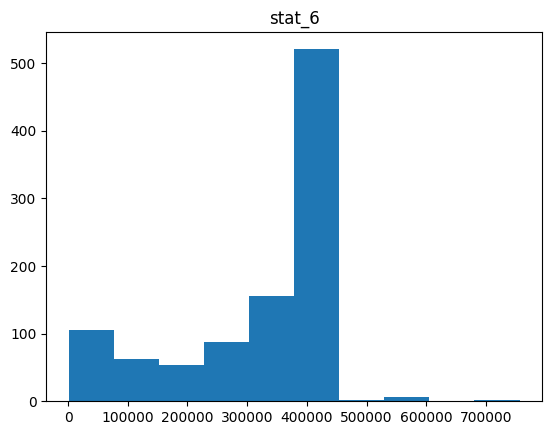

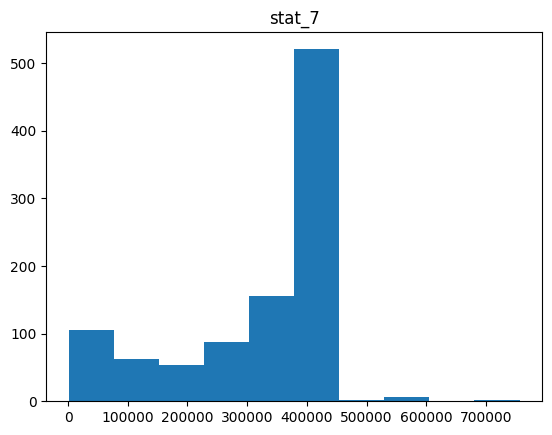

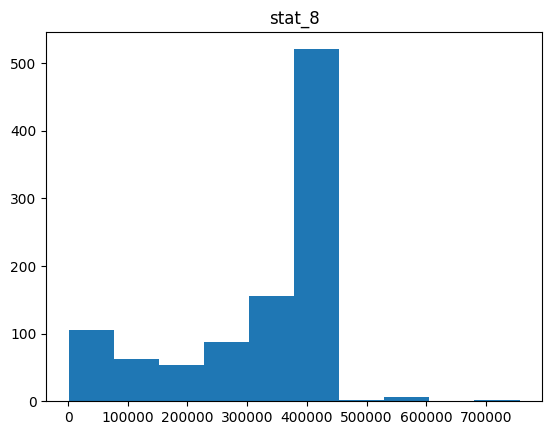

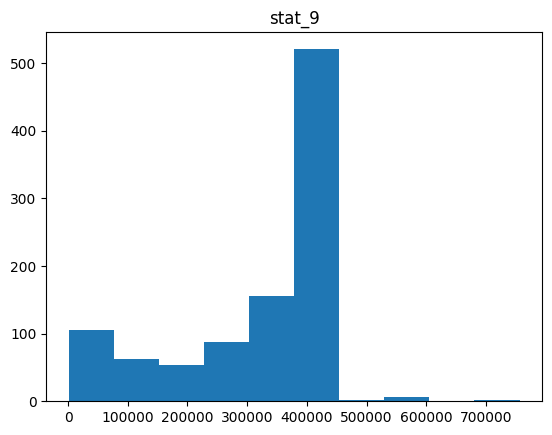

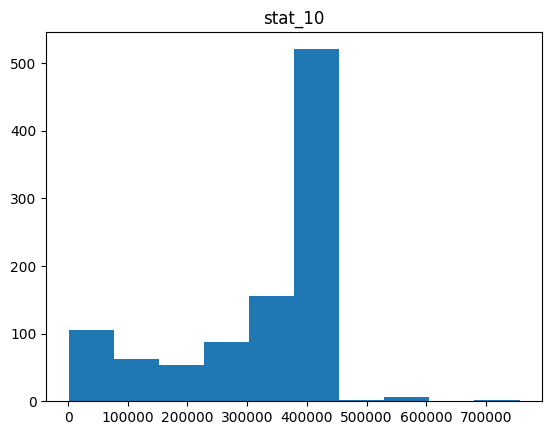

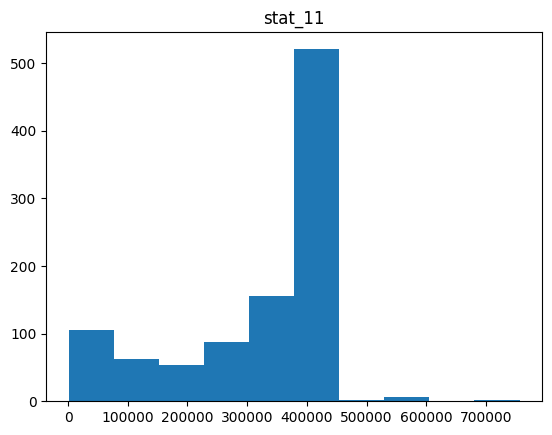

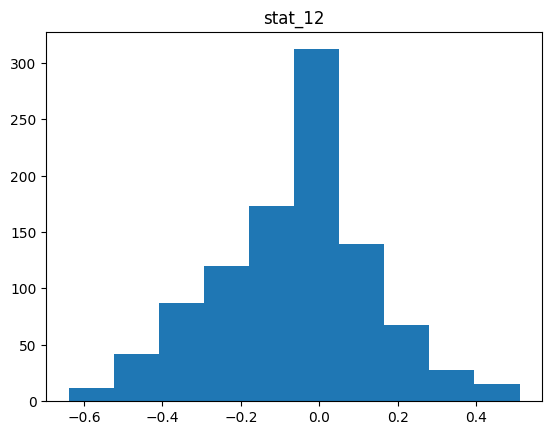

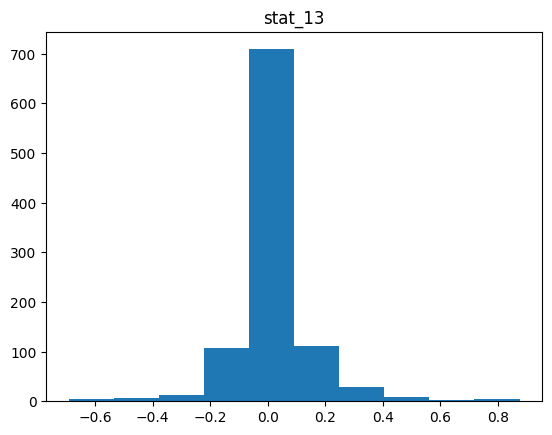

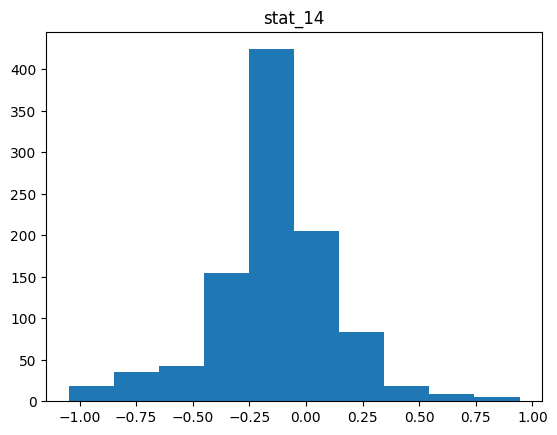

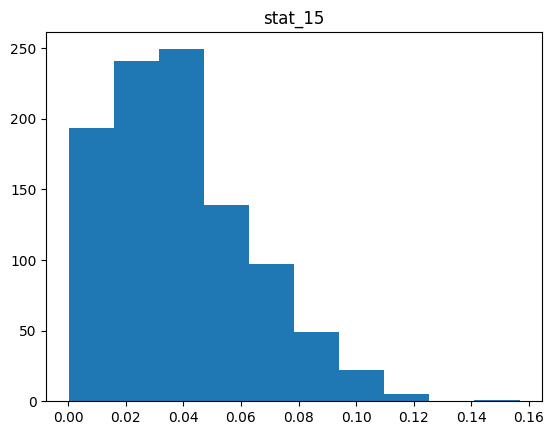

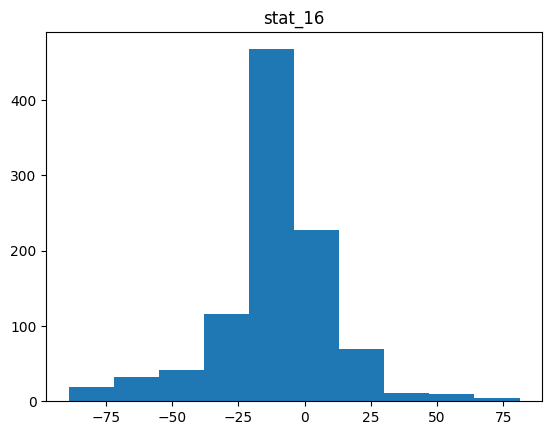

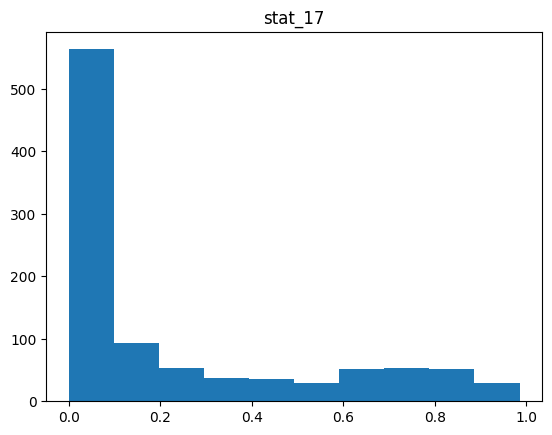

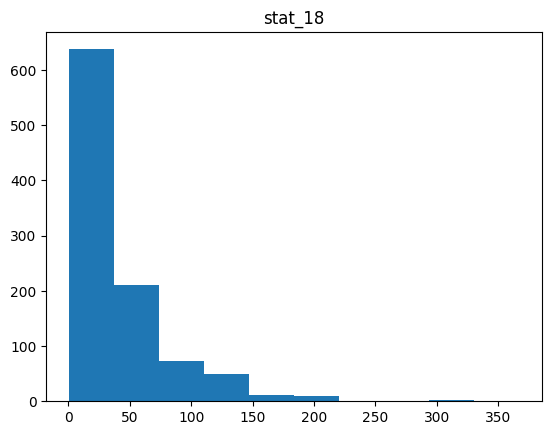

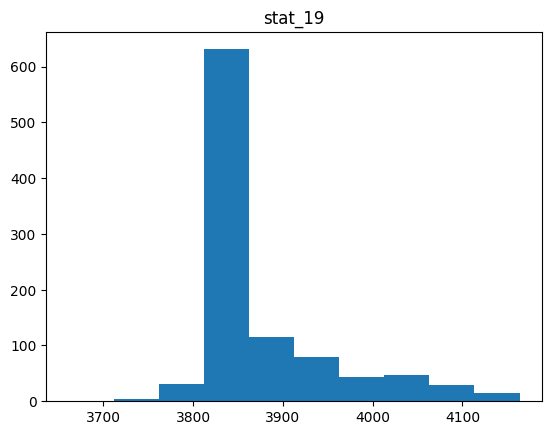

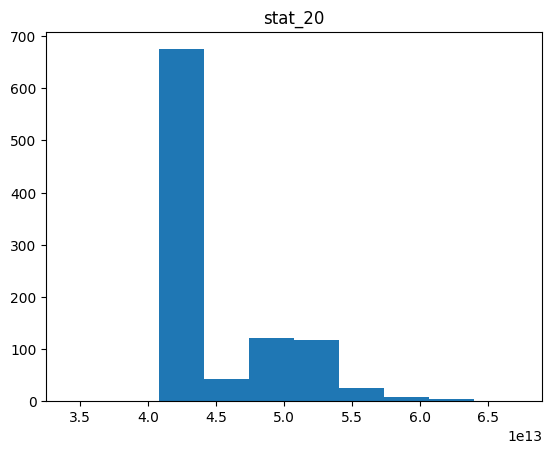

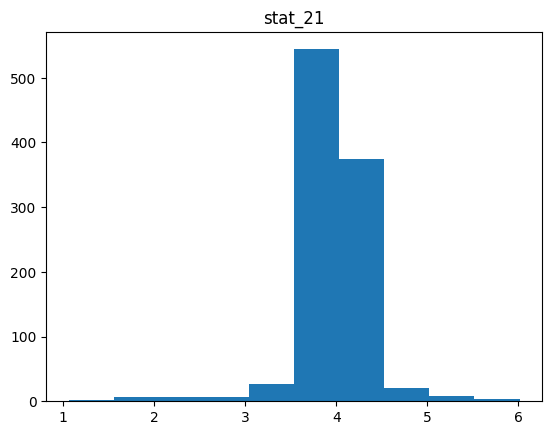

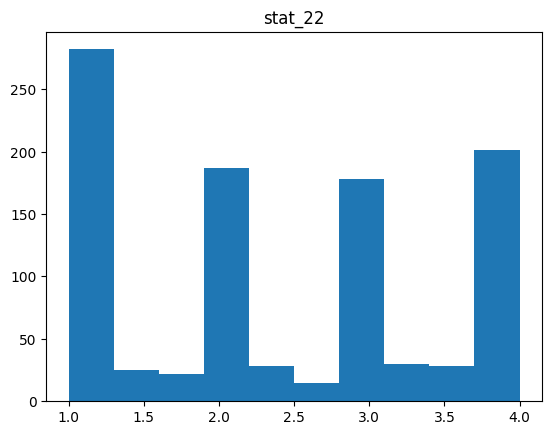

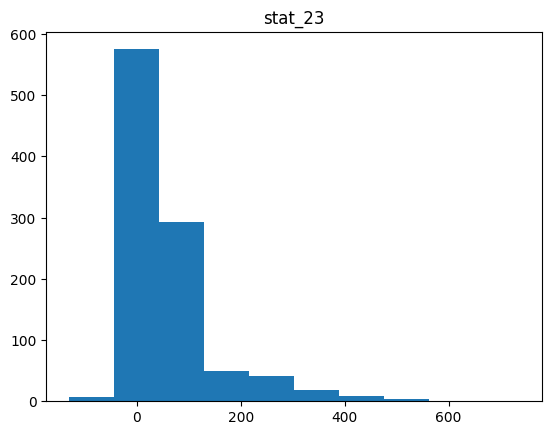

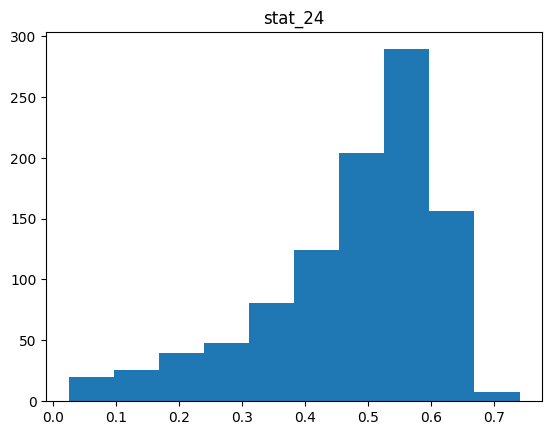

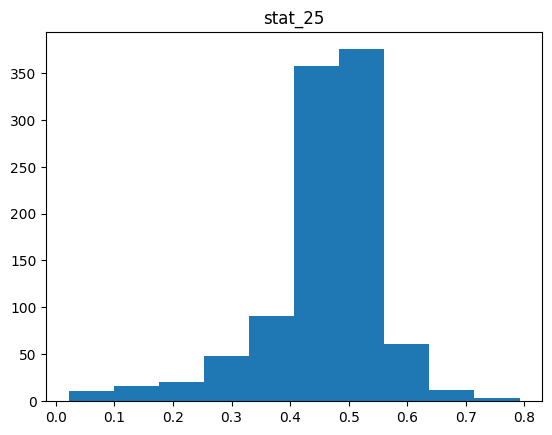

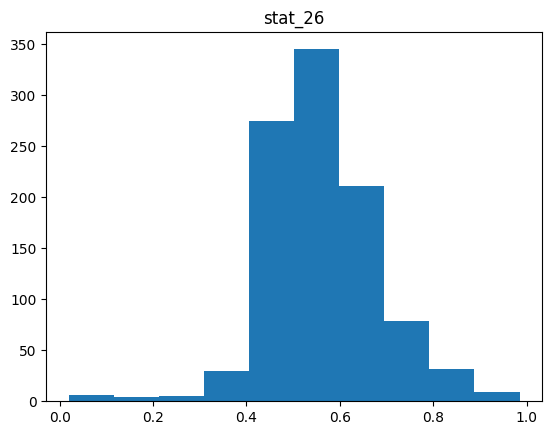

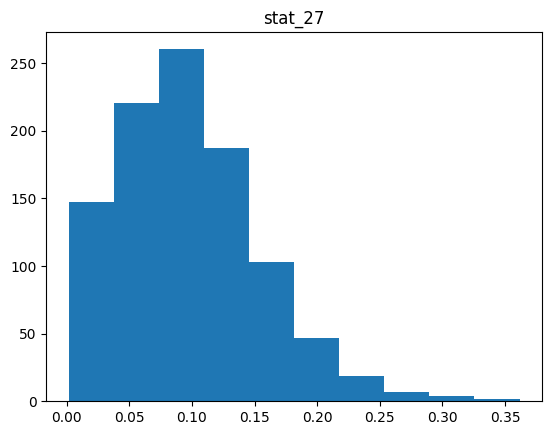

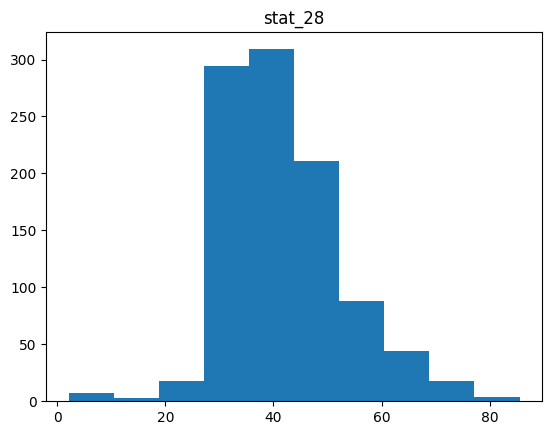

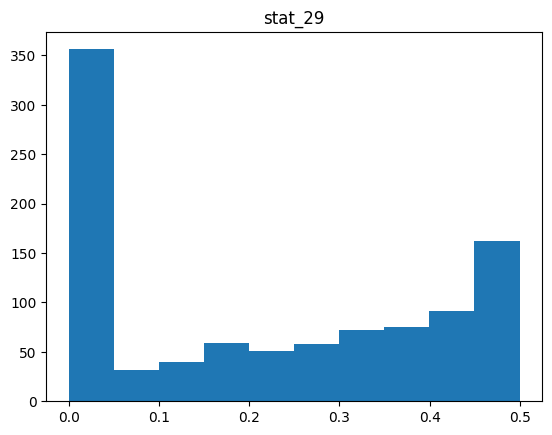

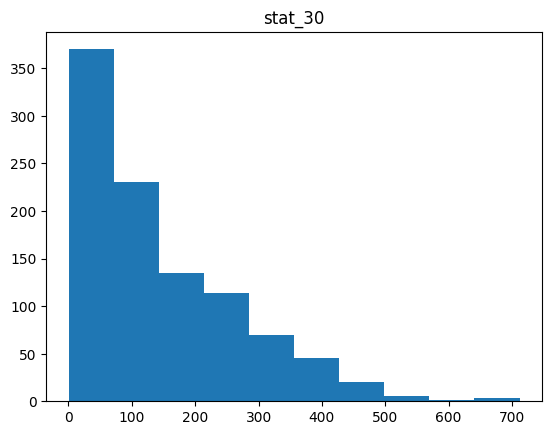

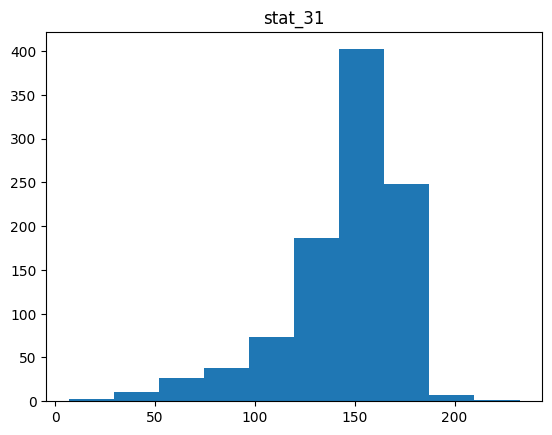

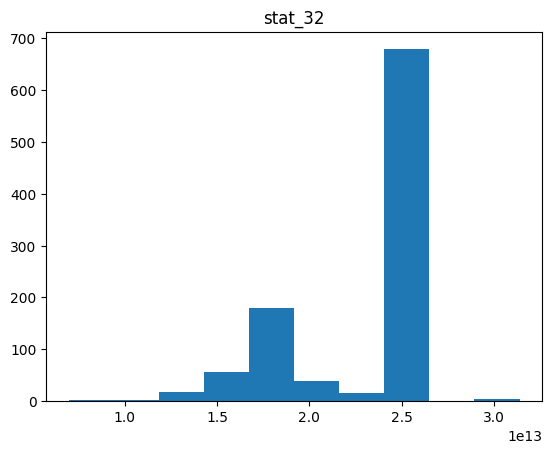

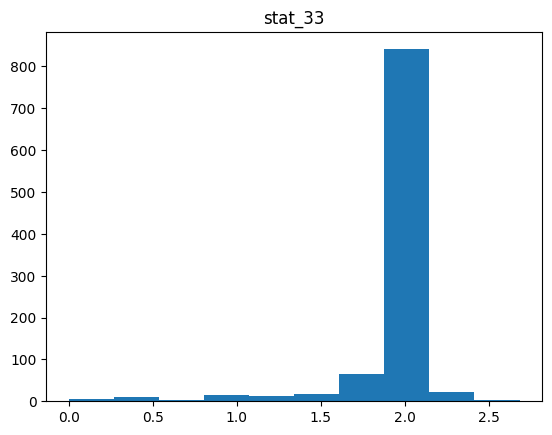

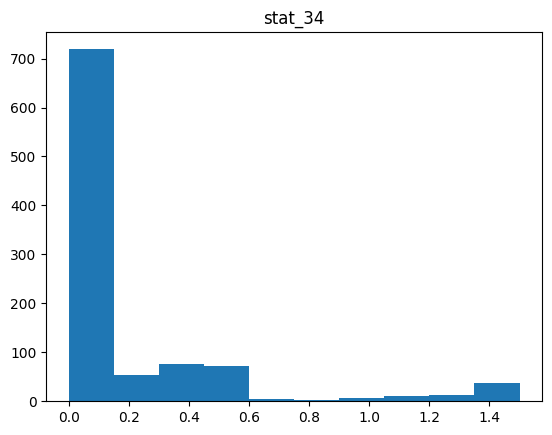

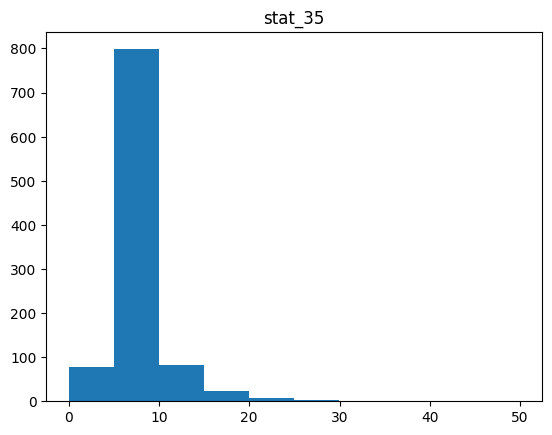

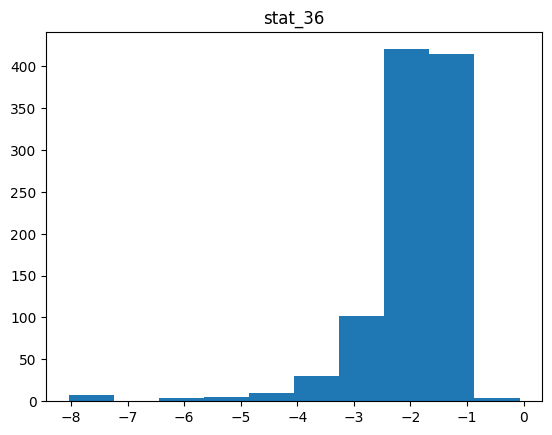

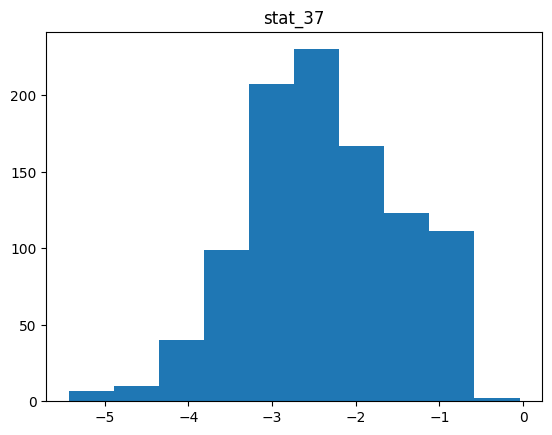

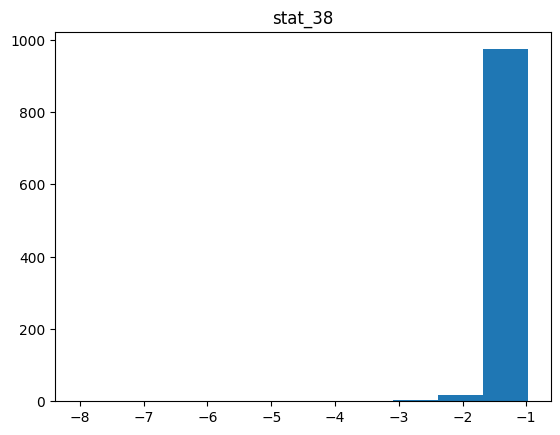

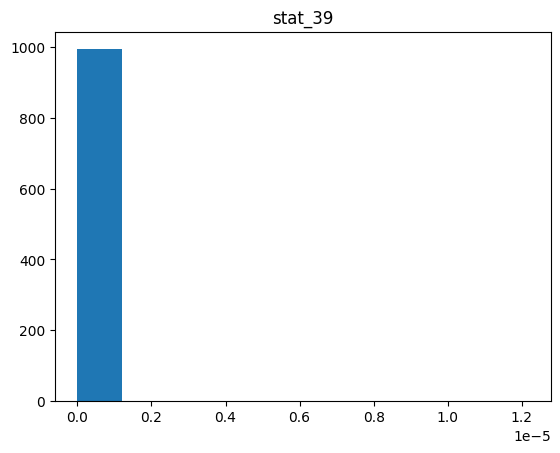

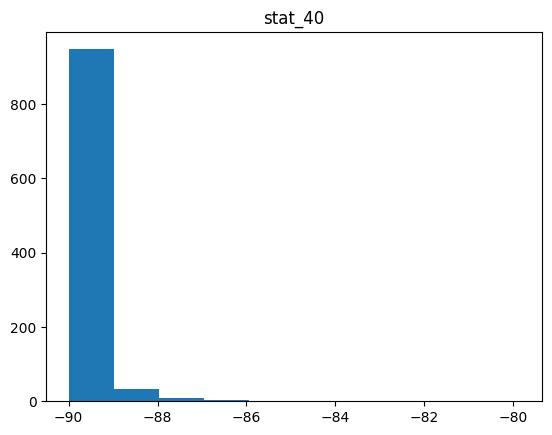

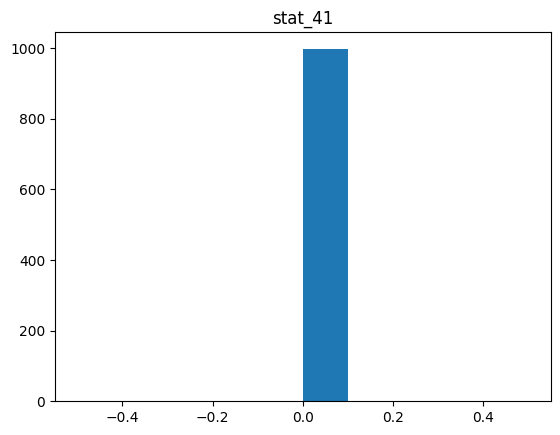

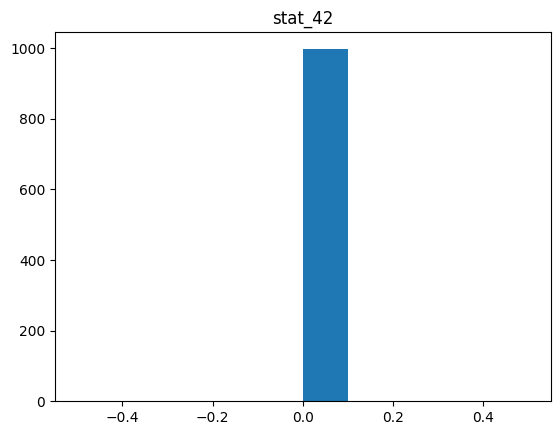

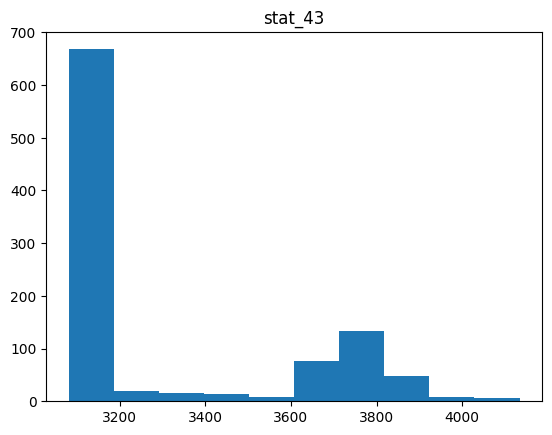

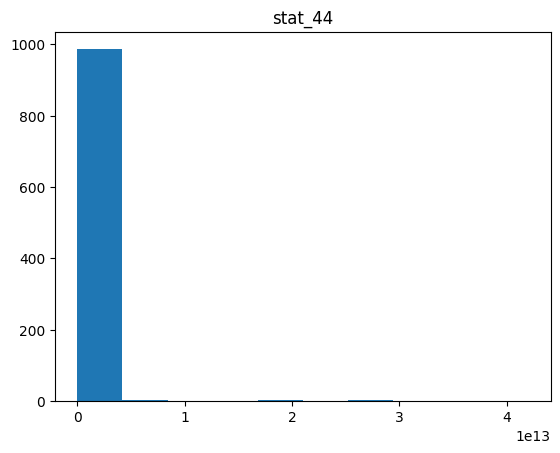

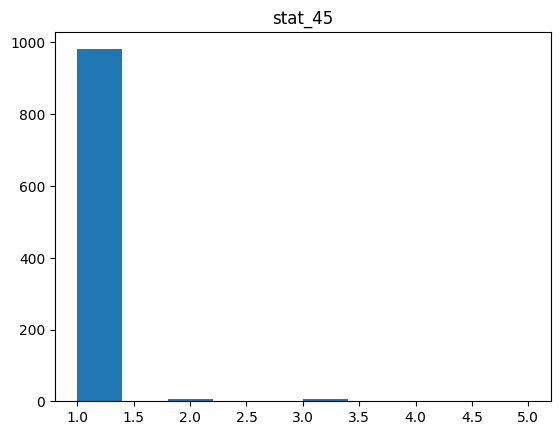

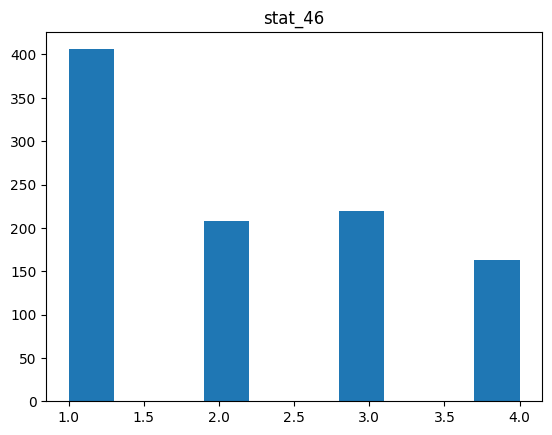

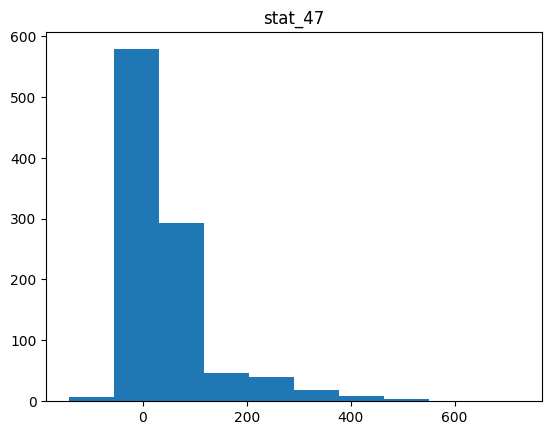

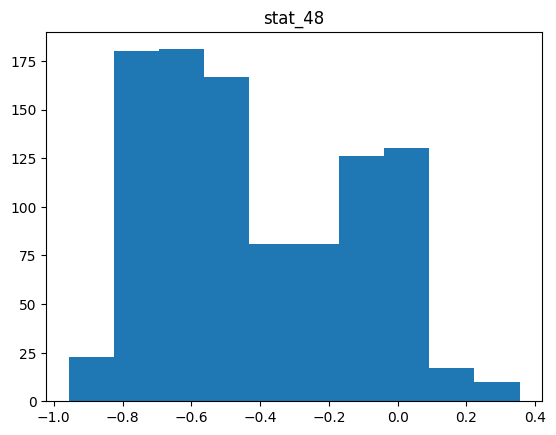

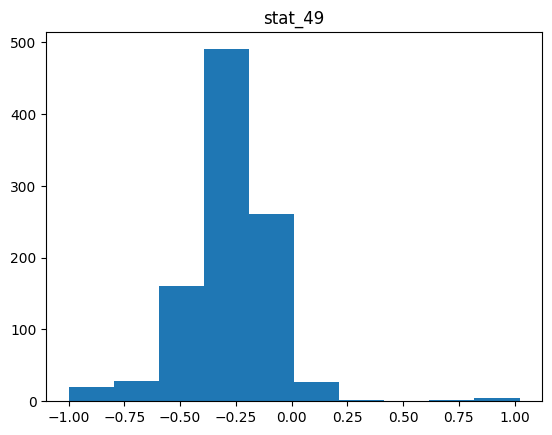

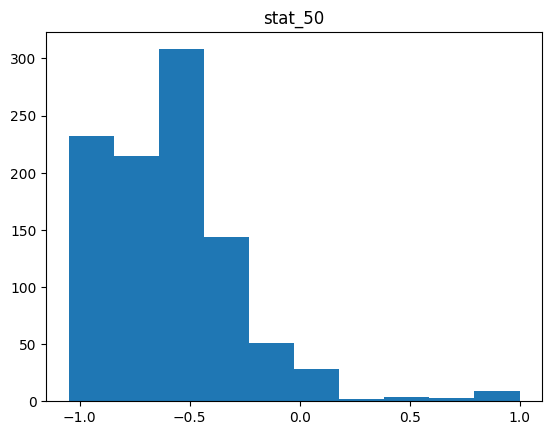

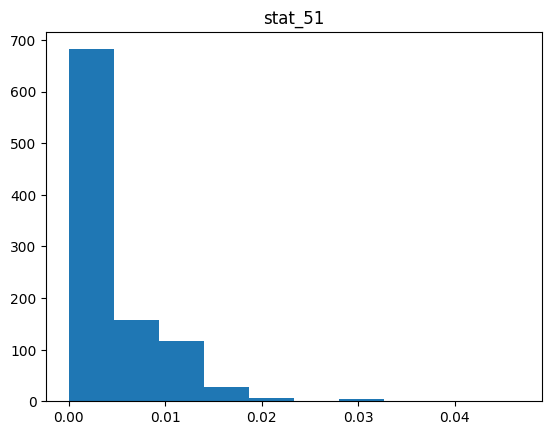

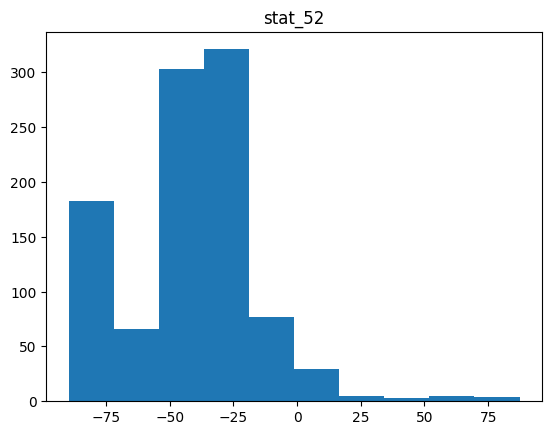

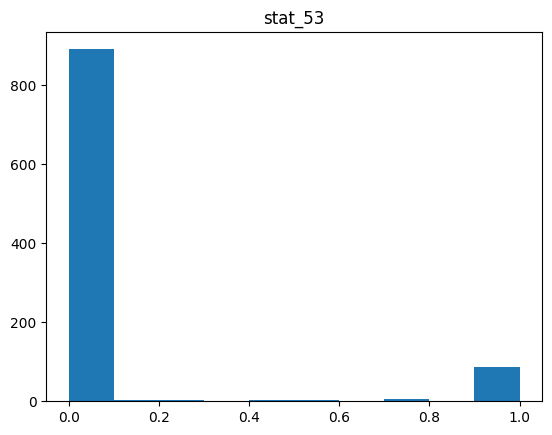

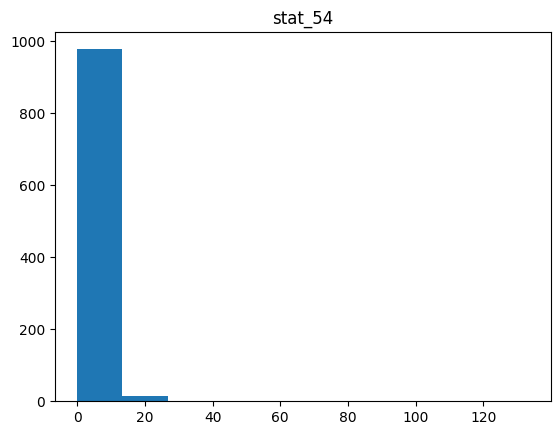

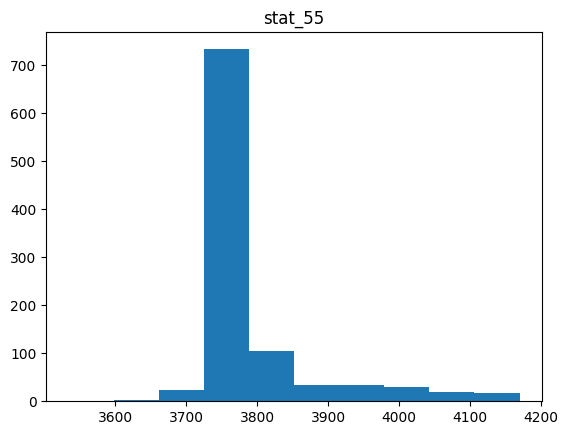

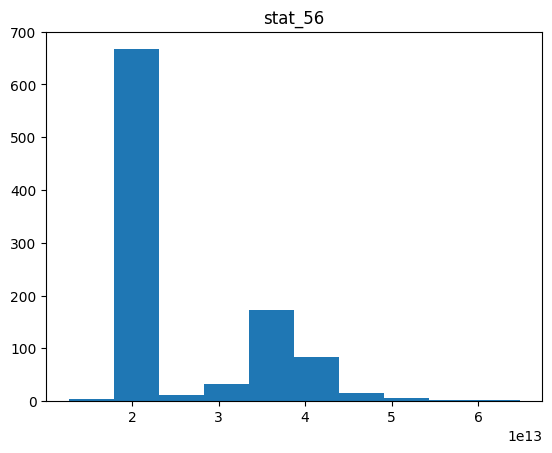

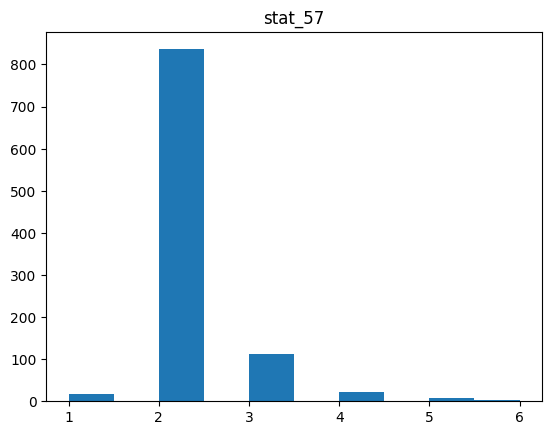

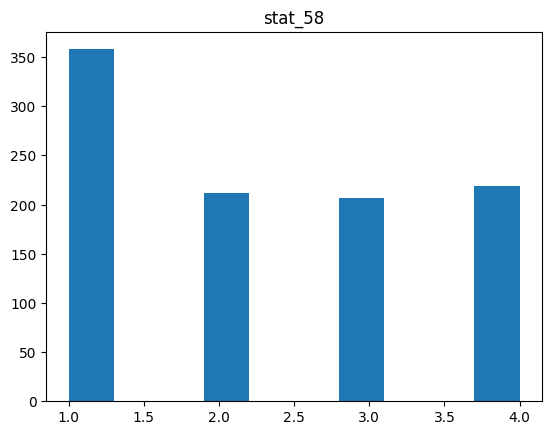

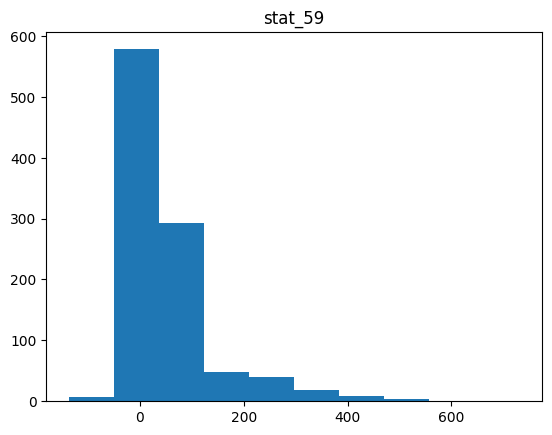

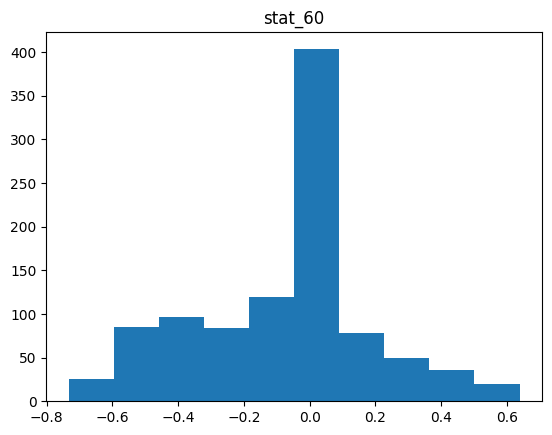

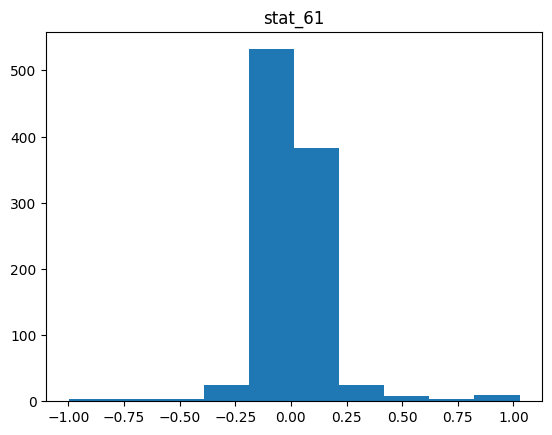

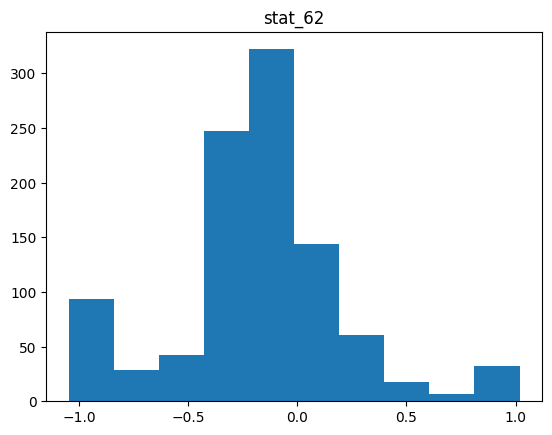

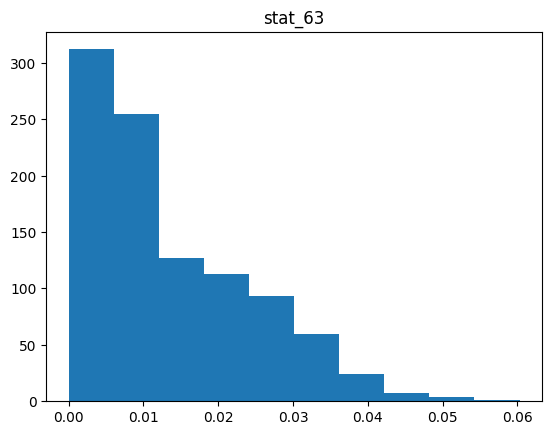

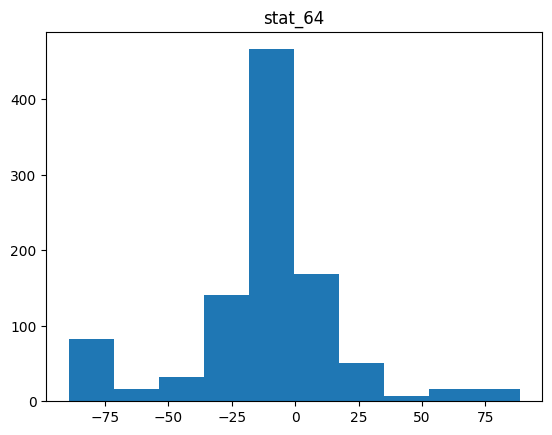

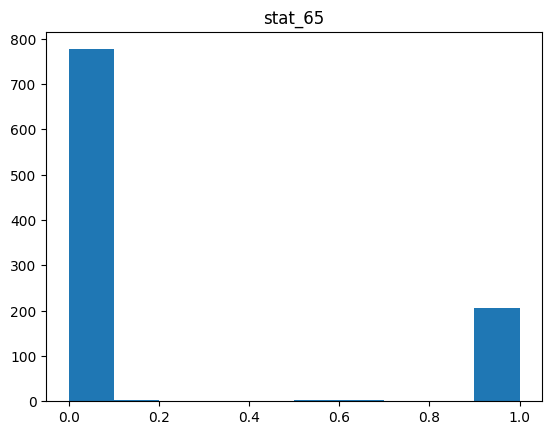

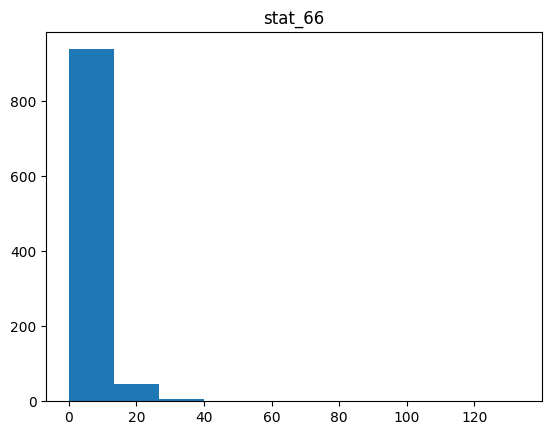

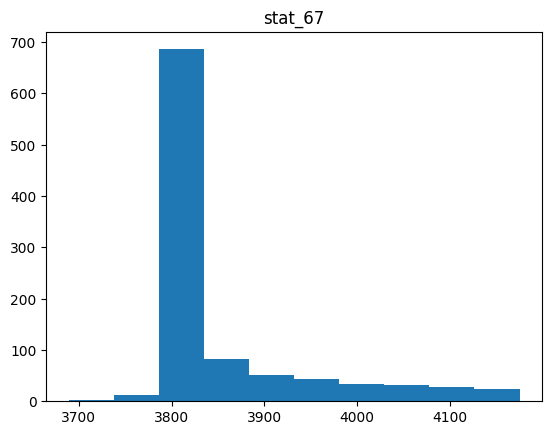

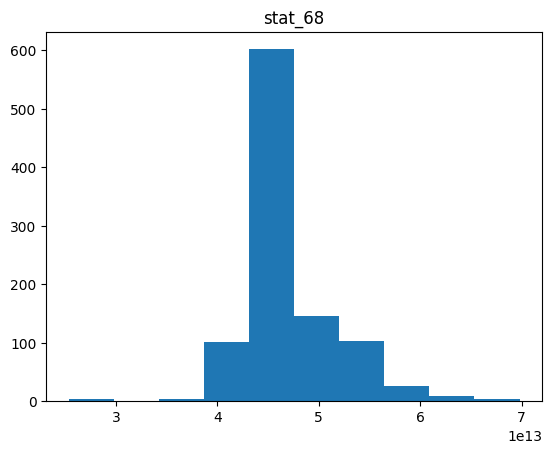

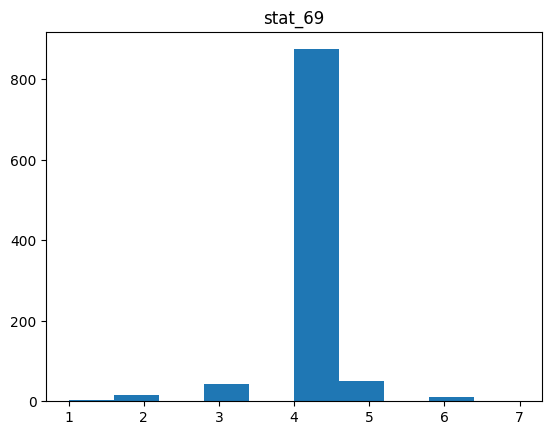

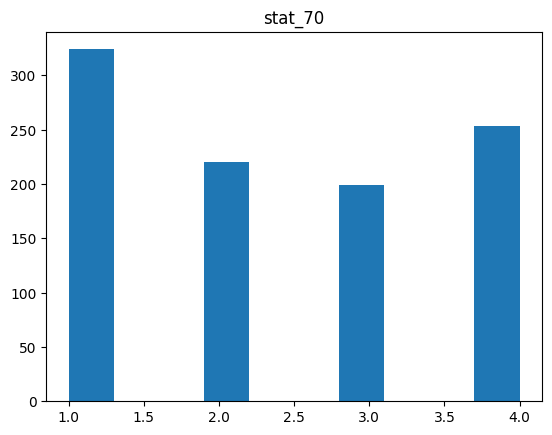

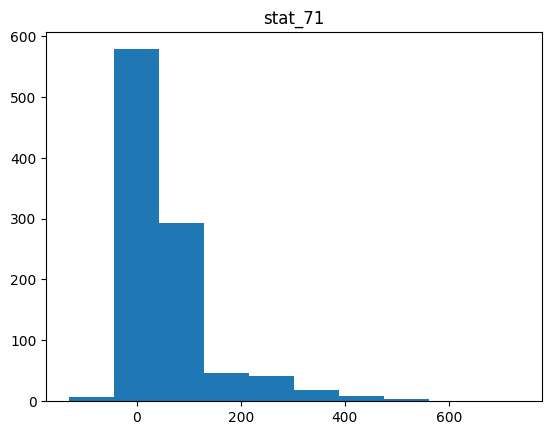

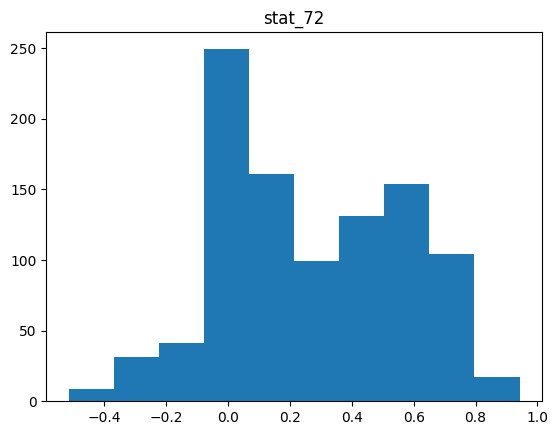

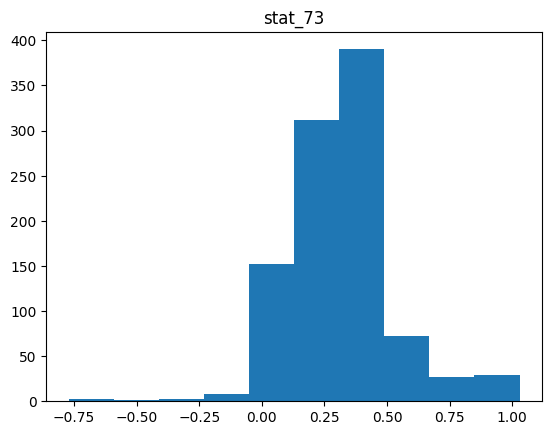

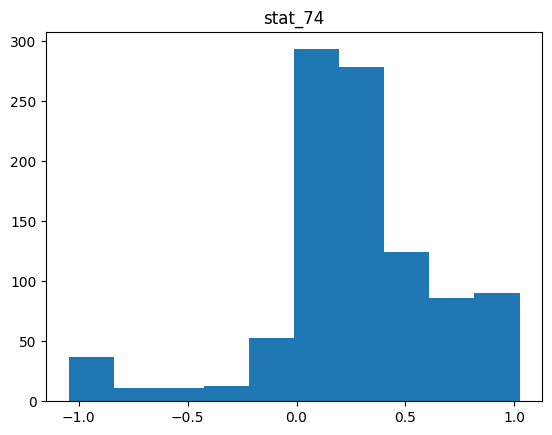

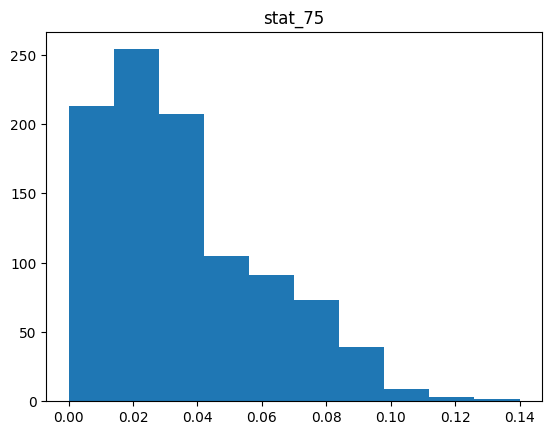

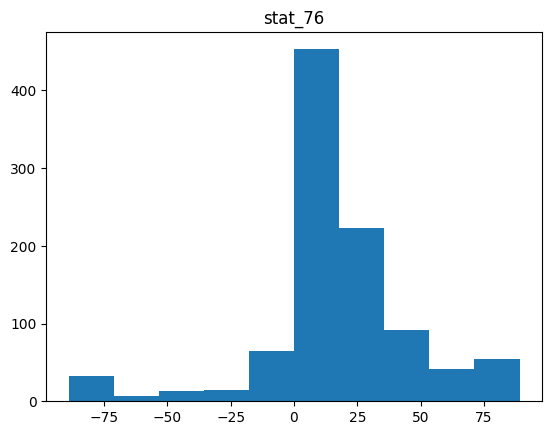

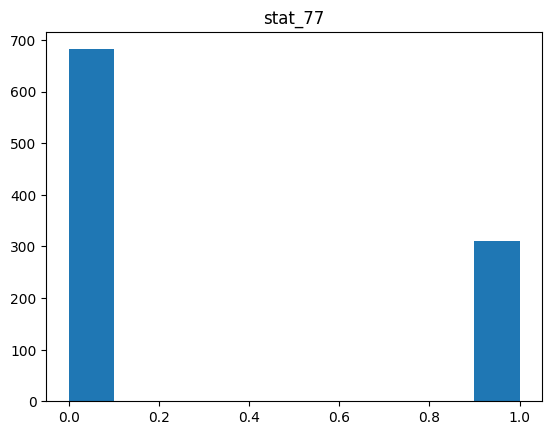

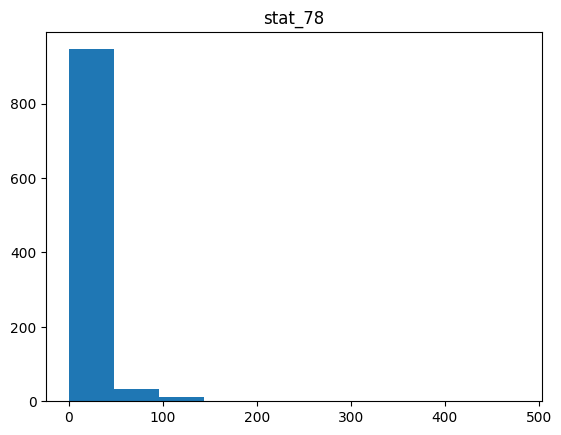

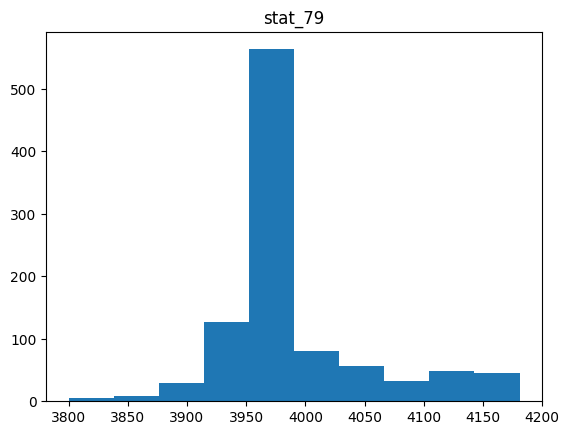

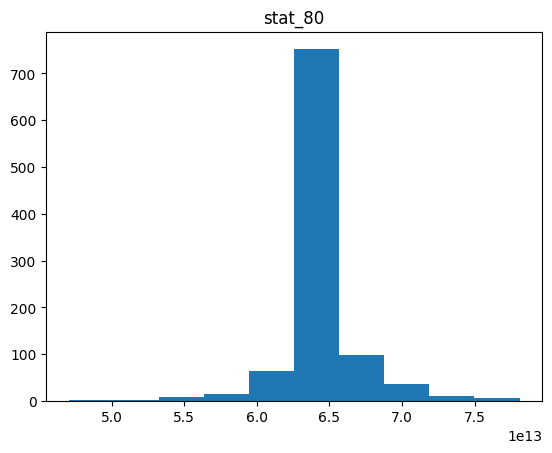

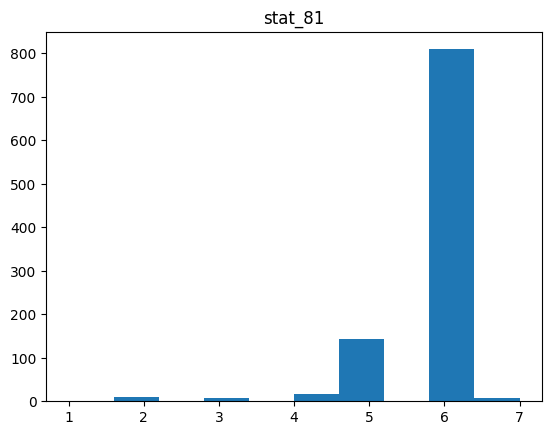

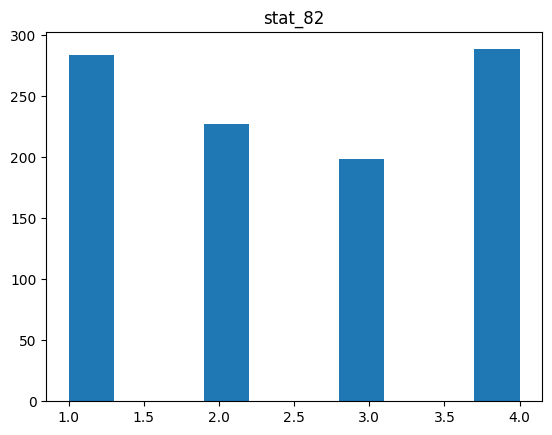

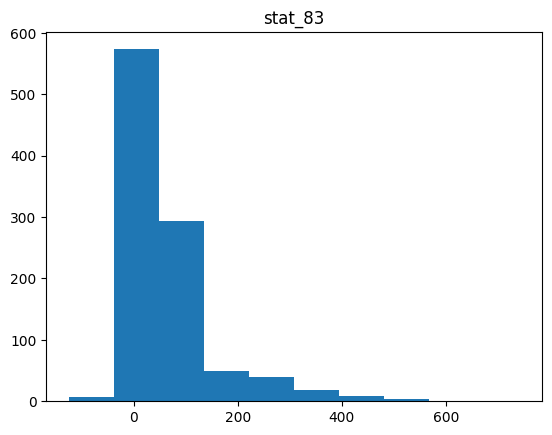

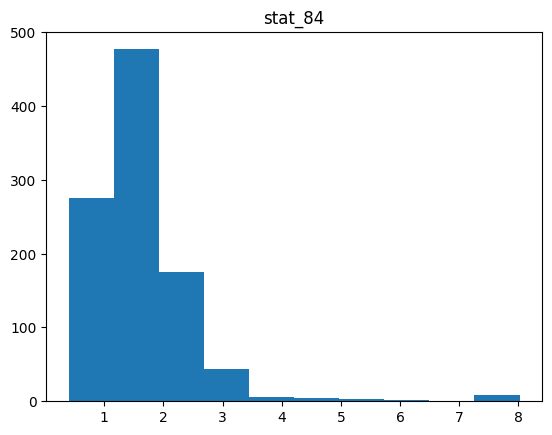

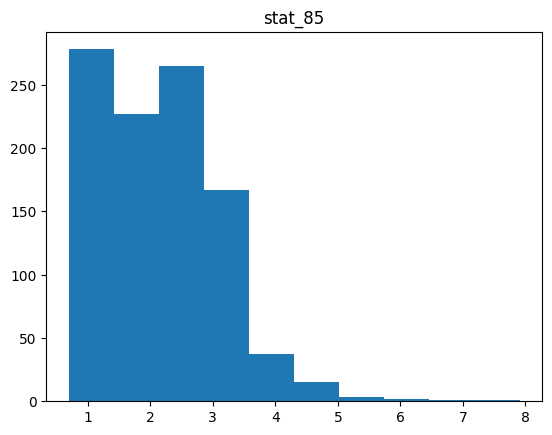

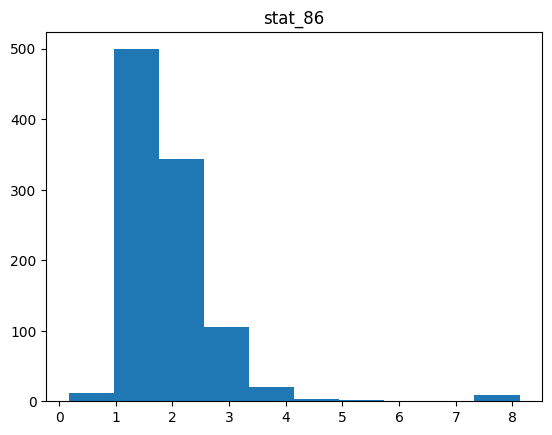

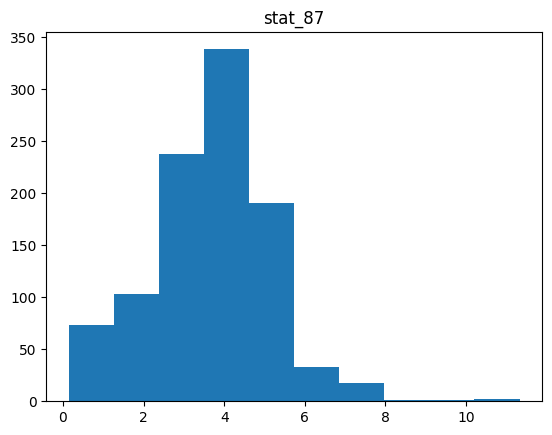

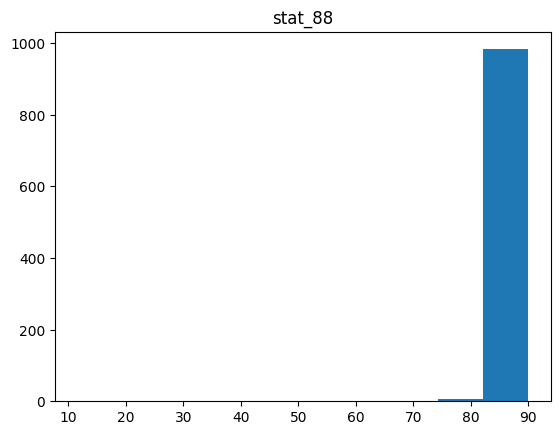

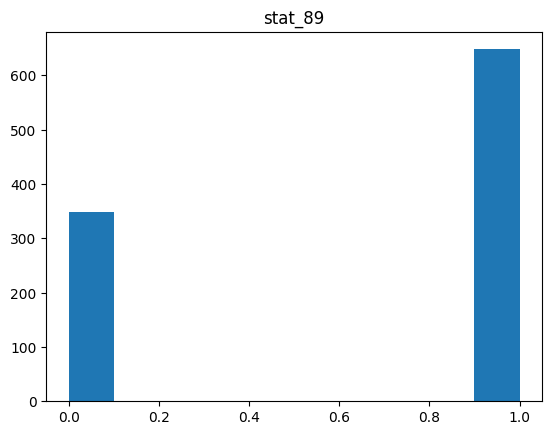

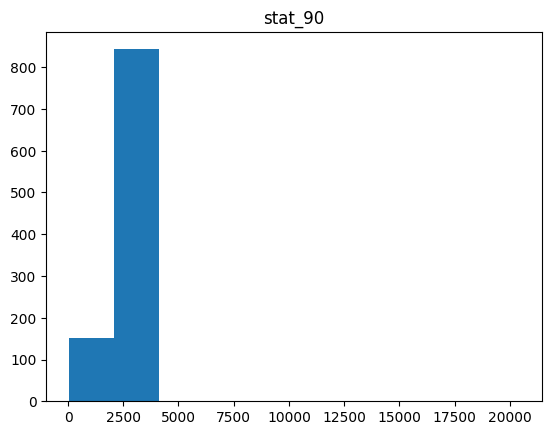

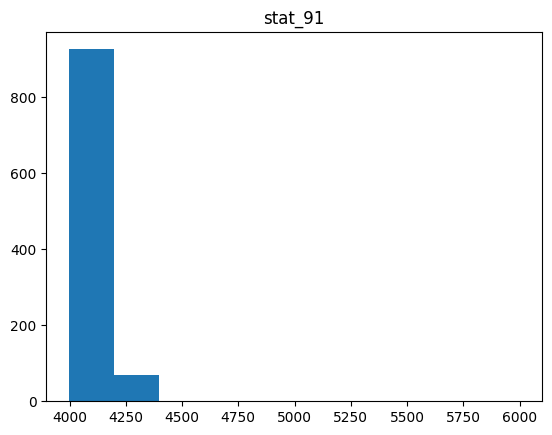

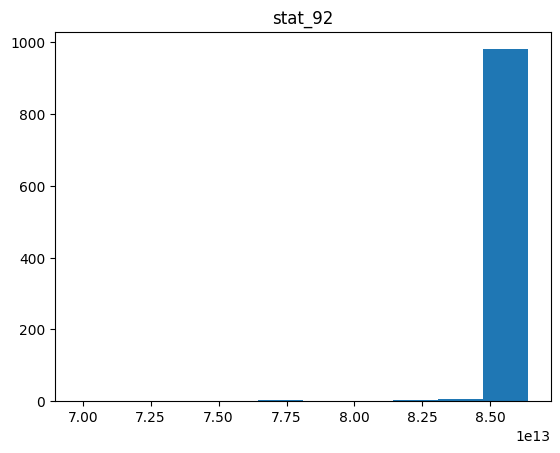

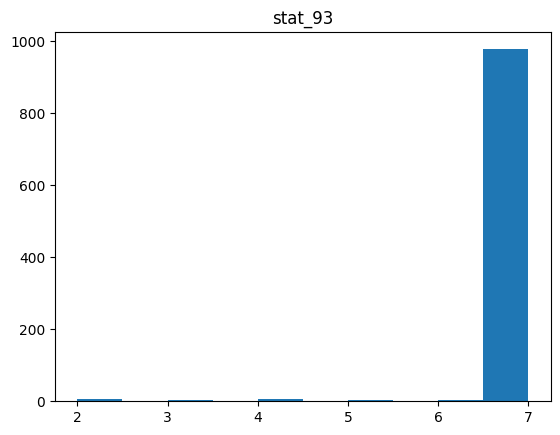

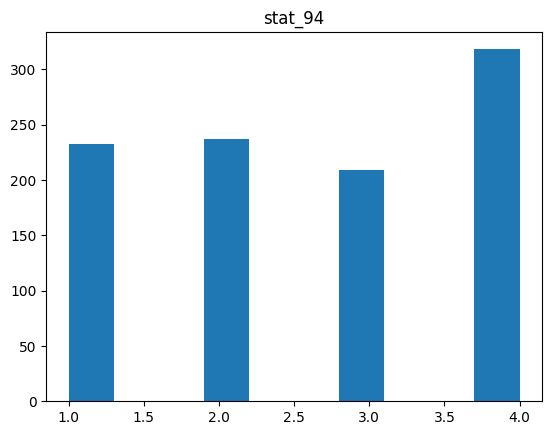

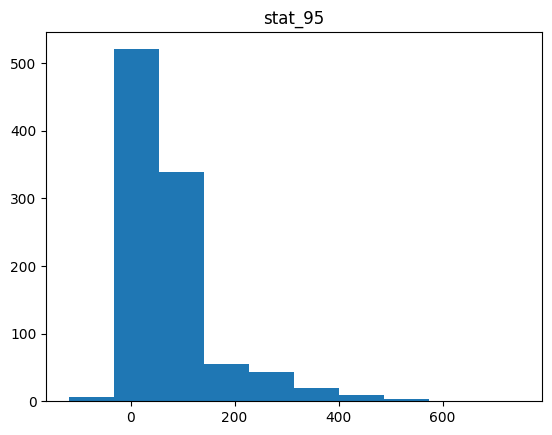

In [9]:
# Data visualization for numerical data
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

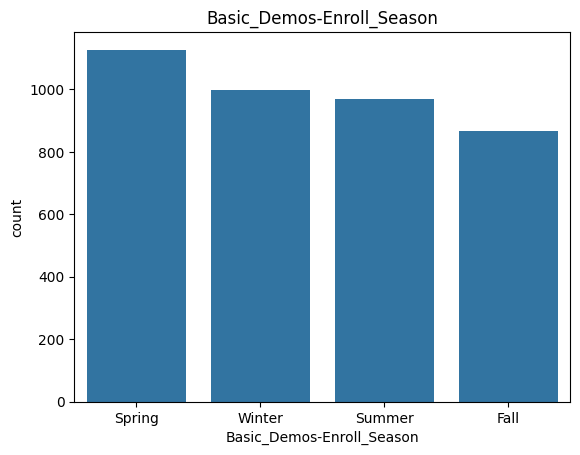

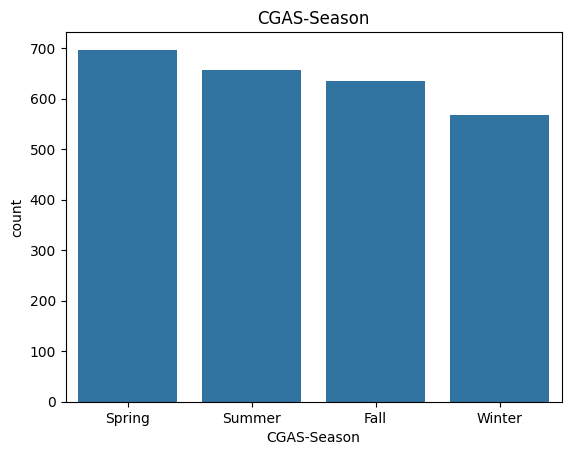

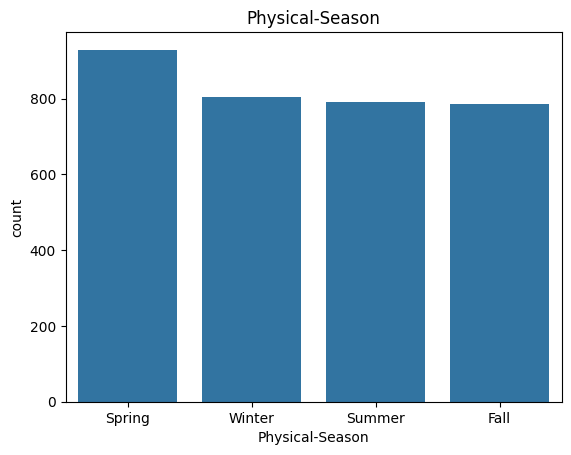

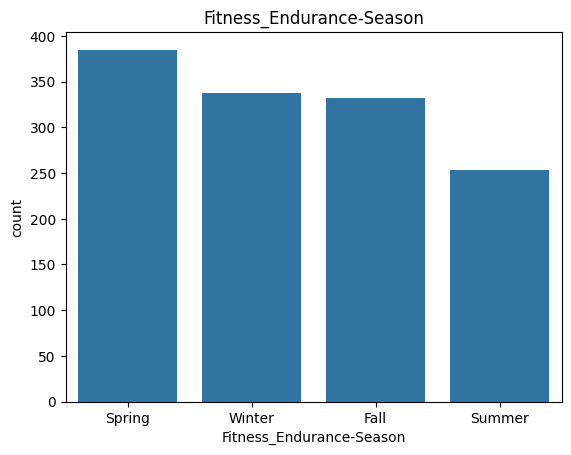

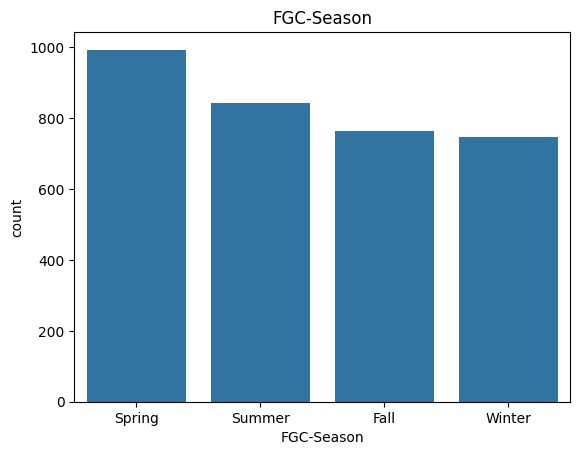

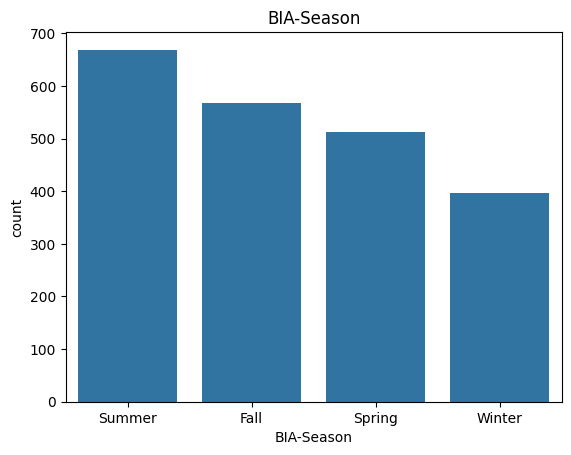

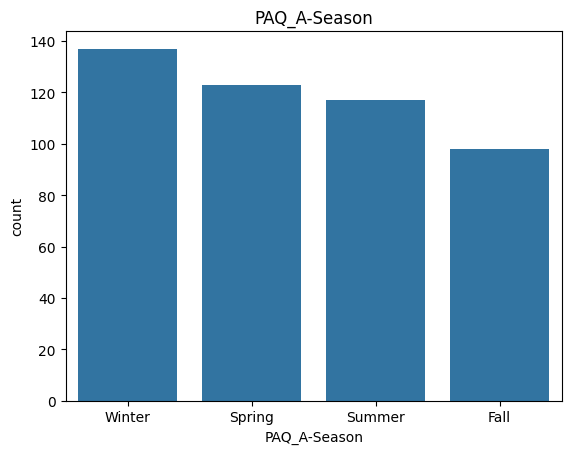

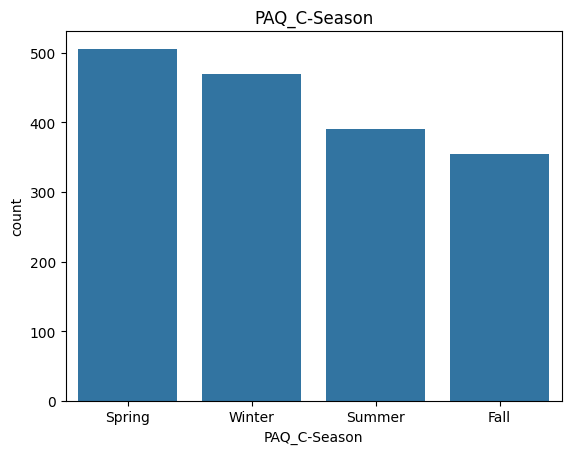

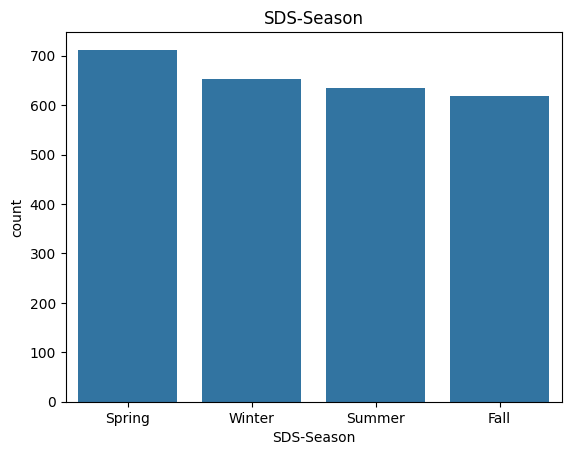

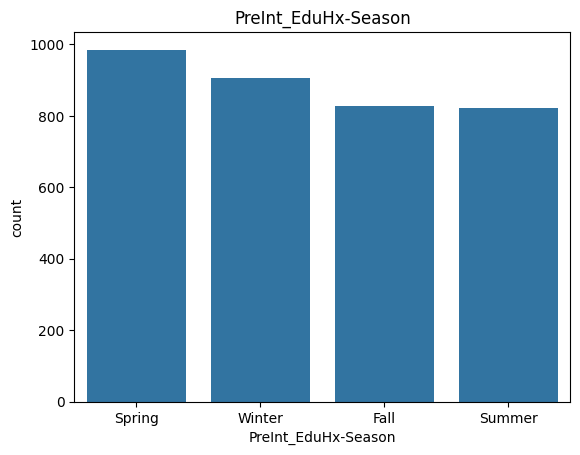

In [10]:
# Data visualization for categorical data
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts()).set_title(
        i
    )
    plt.show()

# Data Preprocessing


In [11]:
# Dropping the 'id' column from both train and test datasets
ids = test_data["id"]
# train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)

# Apply one-hot encoding to categorical columns
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# Align train and test datasets to ensure they have the same columns
# Missing columns will be added with NaN values
train_data, test_data = train_data.align(test_data, join="outer", axis=1)

# Fill missing values with 0 (useful for alignment step)
train_data.fillna(value=0, inplace=True)
test_data.fillna(value=0, inplace=True)

# Print the shapes of the datasets to verify alignment
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Display dataset info to inspect column data types and memory usage
print("\nTrain data info:")
print(train_data.info())
print("\nTest data info:")
print(test_data.info())

# Check for any column differences
difference = train_data.columns.difference(test_data.columns)
if difference.empty:
    print("No column differences between train and test datasets.")
else:
    print("Column differences found:", difference)

# Remove target column 'sii' from test dataset, as it's not available for predictions
test_data = test_data.drop(columns=["sii"], errors="ignore")

# Display final column details
print("\nFinal train columns:", train_data.columns)
print("\nFinal test columns:", test_data.columns)

Train data shape: (3960, 185)
Test data shape: (20, 185)

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Columns: 185 entries, BIA-BIA_Activity_Level_num to stat_95
dtypes: bool(40), float64(143), int64(2)
memory usage: 4.5 MB
None

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 185 entries, BIA-BIA_Activity_Level_num to stat_95
dtypes: bool(35), float64(148), int64(2)
memory usage: 24.2 KB
None
No column differences between train and test datasets.

Final train columns: Index(['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
       ...
       'stat_87', 'stat_88', 'stat_89', 'stat_9', 'stat_90', 'stat_91',
       'stat_92', 'stat_93', 'stat_94', 'stat_95'],
      dtype='object', length=185)

Final test columns: Index(['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BI

# Random Forest Model Predictions


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Prepare features and target
X = train_data.drop(columns=["sii"])
y = train_data["sii"]

# Scale features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.1, random_state=42
)

# Initialize Random Forest with adjusted parameters
RFC = RandomForestClassifier(
    n_estimators=150,  # Reduced number of trees for faster evaluation
    max_depth=10,  # Lower depth for simpler trees
    min_samples_split=10,  # Increase minimum samples required to split
    min_samples_leaf=5,  # Require more samples in leaf nodes
    class_weight="balanced",  # Emphasize minority classes
    random_state=42,
)

# Fit the model
RFC.fit(X_train, y_train)

# Predict on train and test data
y_pred_test = RFC.predict(X_test)
y_pred_train = RFC.predict(X_train)

# Evaluate model
print(
    "Testing data: Model accuracy score : {0:0.4f}".format(
        accuracy_score(y_test, y_pred_test) * 100
    )
)
print(
    "Training data: Model accuracy score : {0:0.4f}".format(
        accuracy_score(y_train, y_pred_train) * 100
    )
)

# Classification report for detailed metrics
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred_test))

# Cross-validation scores for model stability
cv_scores = cross_val_score(RFC, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("\nCross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy: {0:0.4f}".format(np.mean(cv_scores)))

# Feature Importance
feature_importances = pd.DataFrame(
    {
        "Feature": train_data.drop(columns=["sii"]).columns,
        "Importance": RFC.feature_importances_,
    }
).sort_values(by="Importance", ascending=False)

print("\nTop Features by Importance:")
print(feature_importances.head(10))

Testing data: Model accuracy score : 84.9291
Training data: Model accuracy score : 91.0588

Classification Report for Testing Data:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       276
         1.0       0.77      0.71      0.74       283
         2.0       0.78      0.84      0.81       280
         3.0       0.97      1.00      0.98       289

    accuracy                           0.85      1128
   macro avg       0.85      0.85      0.85      1128
weighted avg       0.85      0.85      0.85      1128


Cross-validation Accuracy Scores: [0.79201774 0.84700665 0.84960071 0.86779059 0.84738243]
Mean CV Accuracy: 0.8408

Top Features by Importance:
                                   Feature  Importance
81  PreInt_EduHx-computerinternet_hoursday    0.064223
82                       SDS-SDS_Total_Raw    0.051227
83                         SDS-SDS_Total_T    0.051067
20                         Basic_Demos-Age    0.044727
76          

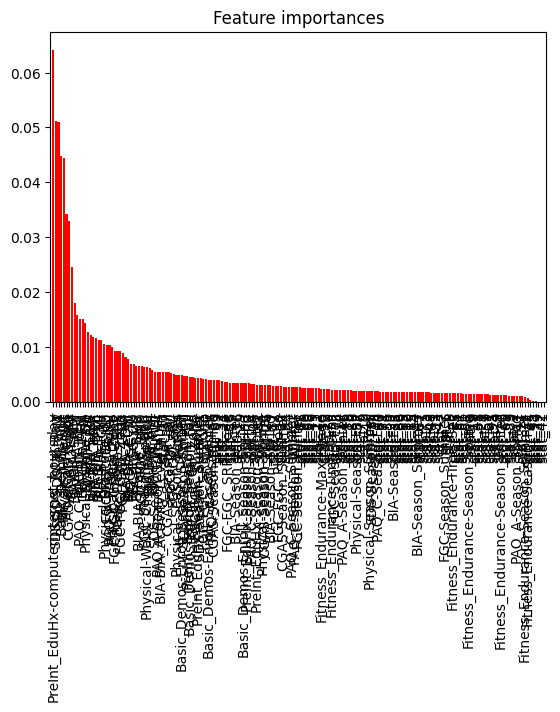

In [13]:
# Get feature importances
columns = train_data.drop(columns=["sii"]).columns

importances = RFC.feature_importances_
indices = np.argsort(importances)[::-1]

# # Summarize feature importances
# print("Feature ranking:")
# for f in range(X_train.shape[1]):
#     print(f"{f + 1}. feature {columns[indices[f]]} ({importances[indices[f]]:.3f})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), [columns[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

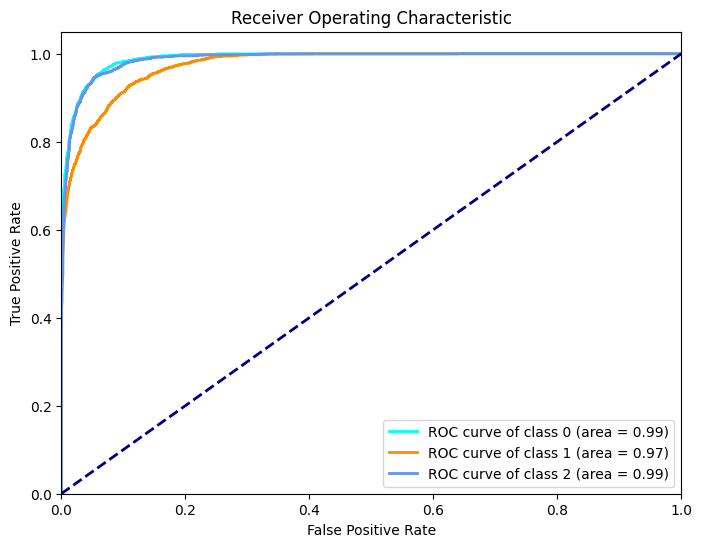

In [15]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Binarize the output
y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3])  # Adjust classes as needed

# Use OneVsRestClassifier for multiclass ROC curve
classifier = OneVsRestClassifier(RFC)
y_pred_train = classifier.fit(X_train, y_train_bin).predict_proba(X_train)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_train_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_pred_train[:, i])
    roc_auc[i] = roc_auc_score(y_train_bin[:, i], y_pred_train[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ["aqua", "darkorange", "cornflowerblue"]
for i, color in zip(range(y_train_bin.shape[1]), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

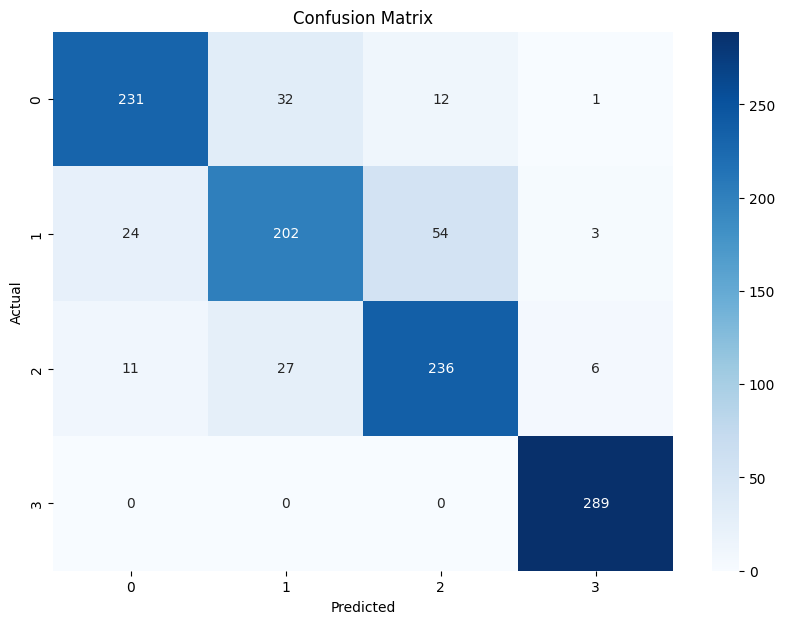

In [16]:
from sklearn import metrics

# Plot confusion matrix
y_pred = RFC.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[0, 1, 2, 3],
    yticklabels=[0, 1, 2, 3],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression Model Predictions


In [17]:
from sklearn.linear_model import LogisticRegression

X = train_data.drop(columns=["sii"])
y = train_data["sii"]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred_test = LR.predict(X_test)
y_pred_train = RFC.predict(X_train)

print(
    "Testing data accuracy: {0:0.4f}".format(accuracy_score(y_test, y_pred_test) * 100)
)
print(
    "Training data accuracy: {0:0.4f}".format(
        accuracy_score(y_train, y_pred_train) * 100
    )
)

Testing data accuracy: 72.2222
Training data accuracy: 83.0808


# Random Forest Predictions On Test Set


In [18]:
X = test_data
X = scaler.fit_transform(X)
y_pred = RFC.predict(X)

submission = pd.DataFrame({"id": ids, "sii": y_pred.astype(int)})
print(submission)

submission.to_csv("submission.csv", index=False)
print("Submission file created.")

          id  sii
0   00008ff9    0
1   000fd460    0
2   00105258    1
3   00115b9f    1
4   0016bb22    0
5   001f3379    0
6   0038ba98    2
7   0068a485    0
8   0069fbed    0
9   0083e397    0
10  0087dd65    0
11  00abe655    0
12  00ae59c9    2
13  00af6387    0
14  00bd4359    0
15  00c0cd71    2
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    2
19  00ebc35d    0
Submission file created.


# Logistic Regression Predictions On Test Set


In [29]:
# Predicting on test data
# X = test_data
# X = scaler.fit_transform(X)
# y_pred = LR.predict(X)

# submission = pd.DataFrame({
#     'id': ids,
#     'sii': y_pred.astype(int)
# })

# #saving to CSV
# submission.to_csv('submission.csv', index=False)
# print(submission)